<a href="https://colab.research.google.com/github/AminFathollahi/NMA_DL/blob/main/tutorials/W1D2_ComparingTasks/student/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D2_ComparingTasks/student/W1D2_Tutorial1.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D2_ComparingTasks/student/W1D2_Tutorial1.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 1: Task definition, application, relations and impacts on generalization

**Week 1, Day 2: Comparing Tasks**

**By Neuromatch Academy**

__Content creators:__ Deying Song, Leila Wehbe

__Content reviewers:__ Samuele Bolotta, Hlib Solodzhuk, RyeongKyung Yoon, Lily Chamakura, Yizhou Chen, Ruiyi Zhang, Patrick Mineault, Alex Murphy

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Patrick Mineault, Alex Murphy


___


# Tutorial Objectives

*Estimated timing of tutorial: 90 minutes*

In this tutorial, we'll explore how task specification affects generalization in networks. We will use the same base architecture (a convolutional neural network / CNN) to perform multiple different tasks. We will explore the number of training points and number of epochs needed to train these networks up to a specific accuracy value. Additionally, we will explore how well representations learned for a given task generalize, and whether these representations can be used to solve the other tasks.

Today's learning objectives are:

1. Formulate different tasks in terms of cost functions
2. Train a network to accomplish these tasks and compare the performance of these networks
3. Measure how well different representations generalize

Let's get started.


In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "x4y79"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

---
# Setup



In [1]:
# @title Install and import feedback gadget

!pip install vibecheck numpy matplotlib torch torchvision tqdm ipywidgets memory-profiler requests scikit-learn torchmetrics --quiet


from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()

feedback_prefix = "W1D2_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# @title Import dependencies

# Import standard library dependencies
import os
import time
import gc
import logging
from pathlib import Path
import zipfile
import random
import contextlib
import io

# Import third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from ipywidgets import Layout
from memory_profiler import profile
import requests
from sklearn.metrics import confusion_matrix
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
import vibecheck
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from pathlib import Path
import time
from tqdm import tqdm

In [3]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# @title Set device (GPU or CPU)

def set_device():
    """
    Determines and sets the computational device for PyTorch operations based on the availability of a CUDA-capable GPU.

    Outputs:
    - device (str): The device that PyTorch will use for computations ('cuda' or 'cpu'). This string can be directly used
    in PyTorch operations to specify the device.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")

    return device

device = set_device()

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


In [5]:
# @title Helper functions



class BottleneckLayer(nn.Module):
    def __init__(self, M):
        super(BottleneckLayer, self).__init__()
        self.fc = nn.Linear(LATENT_DIM, M)

    def forward(self, x):
        x = F.relu(self.fc(x))
        return x

class ConvNeuralNetDecoder(nn.Module):
    def __init__(self, M):
        super(ConvNeuralNetDecoder, self).__init__()
        self.fc3 = nn.Linear(M, LATENT_DIM)
        self.fc2 = nn.Linear(84, 120)
        self.fc1 = nn.Linear(120, 16 * 5 * 5)

        self.convT2 = nn.ConvTranspose2d(16, 6, 5, stride=2, padding=0, output_padding=1)
        self.convT1 = nn.ConvTranspose2d(6, 1, 5, stride=2, padding=0, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc1(x))

        x = x.view(-1, 16, 5, 5)

        x = F.relu(self.convT2(x))
        x = self.convT1(x)

        return x

def get_random_sample_dataloader(dataset, batch_size, M):
    indices = torch.randperm(len(dataset))[:M]
    sampler = SubsetRandomSampler(indices)
    sampled_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, pin_memory=True)

    return sampled_loader

def get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data):

    sampled_train_loader = get_random_sample_dataloader(train_dataset, batch_size, N_train_data)

    N_val_data = int(N_train_data / 9.0)
    if N_val_data < 30:
        N_val_data = 30
    sampled_val_loader = get_random_sample_dataloader(val_dataset, batch_size, N_val_data)

    return sampled_train_loader, sampled_val_loader

class Accuracy:
    def __init__(self, task='multiclass', num_classes=10):
        assert task == 'multiclass', "Only supports `multiclass` task accuracy!"
        self.num_classes = num_classes

    def __call__(self, predicted, target):
        correct = predicted.eq(target.view_as(predicted)).sum().item()
        return correct / predicted.size(0)

def save_model(model, task_name, N_train_data, epoch, train_loss, val_loss):
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    MODEL_NAME = f"ConvNet_{task_name}_{N_train_data}_epoch_{epoch}.pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    print(f"Saving the model: {MODEL_SAVE_PATH}")

    checkpoint = {
        'model_state_dict': model.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }

    torch.save(obj=checkpoint, f=MODEL_SAVE_PATH)

def train(model, train_dataloader, val_dataloader, test_dataloader, cost_fn, optimizer, epochs_max, acc_flag, triplet_flag, task_name, N_train_data):
    tstart = time.time()
    accuracy = Accuracy(task='multiclass', num_classes=10)

    epoch = 0
    val_cost_last = 100000.0
    val_cost_current = 100000.0

    my_epoch = []
    my_train_cost = []
    my_test_cost = []

    train_losses = []
    val_losses = []
    model = model.to(device)

    if triplet_flag:
        for epoch in tqdm(range(1, epochs_max + 1), desc="Training epochs", unit="epoch"):
            my_epoch.append(epoch)

            train_cost = 0.0
            for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(train_dataloader):
                model.train()
                anchor_img, positive_img, negative_img = anchor_img.cuda(), positive_img.cuda(), negative_img.cuda()
                anchor_reconstruct = model(anchor_img)
                positive_reconstruct = model(positive_img)
                negative_reconstruct = model(negative_img)
                cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                train_cost += cost.item()
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
            train_cost /= len(train_dataloader)
            train_losses.append(train_cost)
            my_train_cost.append(train_cost)

            val_cost = 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(val_dataloader):
                    anchor_img, positive_img, negative_img = anchor_img.cuda(), positive_img.cuda(), negative_img.cuda()
                    anchor_reconstruct = model(anchor_img)
                    positive_reconstruct = model(positive_img)
                    negative_reconstruct = model(negative_img)
                    cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                    val_cost += cost.item()
                val_cost /= len(val_dataloader)
                val_cost_last = val_cost_current
                val_cost_current = val_cost
                val_losses.append(val_cost)

            test_cost = 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(test_dataloader):
                    anchor_img, positive_img, negative_img = anchor_img.cuda(), positive_img.cuda(), negative_img.cuda()
                    anchor_reconstruct = model(anchor_img)
                    positive_reconstruct = model(positive_img)
                    negative_reconstruct = model(negative_img)
                    cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                    test_cost += cost.item()
                test_cost /= len(test_dataloader)
                my_test_cost.append(test_cost)

            print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| " +
                  f"Val cost: {val_cost: .5f}| " +
                  f"Test cost: {test_cost: .5f}|")

            save_model(model, task_name, N_train_data, epoch, train_cost, val_cost)

    else:
        for epoch in tqdm(range(1, epochs_max + 1), desc="Training epochs", unit="epoch"):
            my_epoch.append(epoch)

            train_cost, train_acc = 0.0, 0.0
            for batch_idx, (X, y) in enumerate(train_dataloader):
                model.train()
                X = X.to(device)
                y = y.to(device)
                predictions = model(X)
                cost = cost_fn(predictions, y)
                train_cost += cost.item()
                if acc_flag:
                    _, predicted_classes = torch.max(predictions, 1)
                    acc = accuracy(predicted_classes, y)
                    train_acc += acc
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
            train_cost /= len(train_dataloader)
            if acc_flag:
                train_acc /= len(train_dataloader)
            train_losses.append(train_cost)
            my_train_cost.append(train_cost)

            val_cost, val_acc = 0.0, 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (X, y) in enumerate(val_dataloader):
                    X = X.to(device)
                    y = y.to(device)
                    predictions = model(X)
                    cost = cost_fn(predictions, y)
                    val_cost += cost.item()
                    if acc_flag:
                        _, predicted_classes = torch.max(predictions, 1)
                        acc = accuracy(predicted_classes, y)
                        val_acc += acc
                val_cost /= len(val_dataloader)
                val_cost_last = val_cost_current
                val_cost_current = val_cost
                if acc_flag:
                    val_acc /= len(val_dataloader)
            val_losses.append(val_cost)

            test_cost, test_acc = 0.0, 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (X, y) in enumerate(test_dataloader):
                    X = X.to(device)
                    y = y.to(device)
                    predictions = model(X)
                    cost = cost_fn(predictions, y)
                    test_cost += cost.item()
                    if acc_flag:
                        _, predicted_classes = torch.max(predictions, 1)
                        acc = accuracy(predicted_classes, y)
                        test_acc += acc
                test_cost /= len(test_dataloader)
                my_test_cost.append(test_cost)

                if acc_flag:
                    test_acc /= len(test_dataloader)

            if acc_flag:
                print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| Train acc: {train_acc: .5f}| " +
                      f"Val cost: {val_cost: .5f}| Val acc: {val_acc: .5f}| " +
                      f"Test cost: {test_cost: .5f}| Test acc: {test_acc: .5f}")
            else:
                print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| " +
                      f"Val cost: {val_cost: .5f}| " +
                      f"Test cost: {test_cost: .5f}|")

            save_model(model, task_name, N_train_data, epoch, train_cost, val_cost)

    elapsed = time.time() - tstart
    print('Elapsed: %s' % elapsed)

    loss_data = {'train_losses': train_losses, 'val_losses': val_losses}
    torch.save(loss_data, 'loss_data.pth')

    return my_epoch, my_train_cost, val_losses, my_test_cost

def train_transfer(model, train_dataloader, val_dataloader, test_dataloader, cost_fn, optimizer, epochs_max, acc_flag, triplet_flag, task_name, N_train_data):
    tstart = time.time()
    accuracy = Accuracy(task='multiclass', num_classes=10)

    epoch = 0
    val_cost_last = 100000.0
    val_cost_current = 100000.0

    my_epoch = []
    my_train_cost = []
    my_test_cost = []

    train_losses = []
    val_losses = []
    model = model.to(device)

    if triplet_flag:
        for epoch in tqdm(range(1, epochs_max + 1), desc="Training epochs", unit="epoch"):
            my_epoch.append(epoch)

            train_cost = 0.0
            for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(train_dataloader):
                model.train()
                anchor_img, positive_img, negative_img = anchor_img.cuda(), positive_img.cuda(), negative_img.cuda()
                anchor_reconstruct = model(anchor_img)
                positive_reconstruct = model(positive_img)
                negative_reconstruct = model(negative_img)
                cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                train_cost += cost.item()
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
            train_cost /= len(train_dataloader)
            train_losses.append(train_cost)
            my_train_cost.append(train_cost)

            val_cost = 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(val_dataloader):
                    anchor_img, positive_img, negative_img = anchor_img.cuda(), positive_img.cuda(), negative_img.cuda()
                    anchor_reconstruct = model(anchor_img)
                    positive_reconstruct = model(positive_img)
                    negative_reconstruct = model(negative_img)
                    cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                    val_cost += cost.item()
                val_cost /= len(val_dataloader)
                val_cost_last = val_cost_current
                val_cost_current = val_cost
                val_losses.append(val_cost)

            test_cost = 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(test_dataloader):
                    anchor_img, positive_img, negative_img = anchor_img.cuda(), positive_img.cuda(), negative_img.cuda()
                    anchor_reconstruct = model(anchor_img)
                    positive_reconstruct = model(positive_img)
                    negative_reconstruct = model(negative_img)
                    cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                    test_cost += cost.item()
                test_cost /= len(test_dataloader)
                my_test_cost.append(test_cost)

            print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| " +
                  f"Val cost: {val_cost: .5f}| " +
                  f"Test cost: {test_cost: .5f}|")

            save_model(model, task_name, N_train_data, epoch, train_cost, val_cost)

    else:
        for epoch in tqdm(range(1, epochs_max + 1), desc="Training epochs", unit="epoch"):
            my_epoch.append(epoch)

            train_cost, train_acc = 0.0, 0.0
            for batch_idx, (X, y) in enumerate(train_dataloader):
                model.train()
                X = X.to(device)
                y = y.to(device)
                predictions = model(X)
                cost = cost_fn(predictions, y)
                train_cost += cost.item()
                if acc_flag:
                    _, predicted_classes = torch.max(predictions, 1)
                    acc = accuracy(predicted_classes, y)
                    train_acc += acc
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
            train_cost /= len(train_dataloader)
            if acc_flag:
                train_acc /= len(train_dataloader)
            train_losses.append(train_cost)
            my_train_cost.append(train_cost)

            val_cost, val_acc = 0.0, 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (X, y) in enumerate(val_dataloader):
                    X = X.to(device)
                    y = y.to(device)
                    predictions = model(X)
                    cost = cost_fn(predictions, y)
                    val_cost += cost.item()
                    if acc_flag:
                        _, predicted_classes = torch.max(predictions, 1)
                        acc = accuracy(predicted_classes, y)
                        val_acc += acc
                val_cost /= len(val_dataloader)
                val_cost_last = val_cost_current
                val_cost_current = val_cost
                if acc_flag:
                    val_acc /= len(val_dataloader)
            val_losses.append(val_cost)

            test_cost, test_acc = 0.0, 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (X, y) in enumerate(test_dataloader):
                    X = X.to(device)
                    y = y.to(device)
                    predictions = model(X)
                    cost = cost_fn(predictions, y)
                    test_cost += cost.item()
                    if acc_flag:
                        _, predicted_classes = torch.max(predictions, 1)
                        acc = accuracy(predicted_classes, y)
                        test_acc += acc
                test_cost /= len(test_dataloader)
                my_test_cost.append(test_cost)

                if acc_flag:
                    test_acc /= len(test_dataloader)

            if acc_flag:
                print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| Train acc: {train_acc: .5f}| " +
                      f"Val cost: {val_cost: .5f}| Val acc: {val_acc: .5f}| " +
                      f"Test cost: {test_cost: .5f}| Test acc: {test_acc: .5f}")
            else:
                print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| " +
                      f"Val cost: {val_cost: .5f}| " +
                      f"Test cost: {test_cost: .5f}|")

            save_model(model, task_name, N_train_data, epoch, train_cost, val_cost)

    elapsed = time.time() - tstart
    print('Elapsed: %s' % elapsed)

    loss_data = {'train_losses': train_losses, 'val_losses': val_losses}
    torch.save(loss_data, 'loss_data.pth')

    return my_epoch, my_train_cost, val_losses, my_test_cost

In [6]:
# @title Plotting functions

def plot_reconstructions(original_images, reconstructed_images, N_train_data, epochs):
    fig = plt.figure(figsize=(10, 5))
    rows, cols = 2, 6
    image_count = 0
    for i in range(1, rows * cols, 2):
        fig.add_subplot(rows, cols, i)
        plt.imshow(np.squeeze(original_images[image_count]), cmap='gray')
        plt.title(f"Original {image_count+1}", fontsize=8)
        plt.axis('off')

        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(np.squeeze(reconstructed_images[image_count]), cmap='gray')
        plt.title(f"Reconstructed {image_count+1}", fontsize=8)
        plt.axis('off')

        image_count += 1
    fig.suptitle(f"Training for {epochs} epochs with {N_train_data} points")
    plt.show()

def cost_classification(output, target):
    criterion = nn.CrossEntropyLoss()
    target = target.to(torch.int64)
    cost = criterion(output, target)
    return cost

def cost_regression(output, target):
    criterion = nn.MSELoss()
    cost = criterion(output, target)
    return cost

def cost_autoencoder(output, target):
    criterion = nn.MSELoss()
    output_flat = output.view(output.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    cost = criterion(output_flat, target_flat)
    return cost

In [7]:
# @title Data retrieval

import os
import requests
import hashlib
import zipfile

def download_file(fname, url, expected_md5):
    """
    Downloads a file from the given URL and saves it locally.
    """
    if not os.path.isfile(fname):
        try:
            r = requests.get(url)
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
            return
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
            return
        if hashlib.md5(r.content).hexdigest() != expected_md5:
            print("!!! Data download appears corrupted !!!")
            return
        with open(fname, "wb") as fid:
            fid.write(r.content)

def extract_zip(zip_fname):
    """
    Extracts a ZIP file to the current directory.
    """
    with zipfile.ZipFile(zip_fname, 'r') as zip_ref:
        zip_ref.extractall(".")

# Details for the zip files to be downloaded and extracted
zip_files = [
    {
        "fname": "models.zip",
        "url": "https://osf.io/dms2n/download",
        "expected_md5": "2c88be8804ae546da6c6985226bc98e7"
    }
]

# Process zip files: download and extract
for zip_file in zip_files:
    download_file(zip_file["fname"], zip_file["url"], zip_file["expected_md5"])
    extract_zip(zip_file["fname"])

In [8]:
# @title Set random seed

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

---
# Section 1: Tasks as Cost Functions

We formalize different tasks as cost functions and train the same base architecture on the same dataset. Check out the video below to learn more about how we will do this!

In [ ]:
# @title Tutorial Video

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'HxovwyQTi0o'), ('Bilibili', 'BV1Ri421e7mR')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Tutorial_Video")

## Review of CNNs

In this tutorial, we will use a simple Convolutional Neural Network (CNN) architecture and a subset of the MNIST dataset, which consists of images of handwritten digits (See the Intro video for more information on MNIST). We will use the same base architecture and training dataset to accomplish different tasks by creating various output layers (heads) and train them with different cost functions, thereby specifying different tasks to be completed. With different cost functions, the networks are forced to pay attention to different things as their end goal has changed and it's this property that changes what the network tries *to do*.

A Convolutional Neural Network (CNN) is a deep learning algorithm designed to process input images, assign importance (learnable weights and biases) to various features within the images, and distinguish between different objects. Unlike pure feedforward neural networks that flatten the input into a one-dimensional array, CNNs preserve the spatial structure of the input images. This makes them particularly effective for processing data with a grid-like structure, such as images. A CNN architecture is engineered to automatically and adaptively learn spatial hierarchies of features, ranging from low-level (basic) to high-level (complex) patterns.

The core components of CNNs are convolutional layers, pooling layers, and fully connected layers. A schematic of a CNN is shown below.

- Convolutional layers apply convolution operations to the input and pass the results to the next layer. This enables the network to be deep with fewer parameters, enhancing the learning of feature hierarchies.
- Pooling layers reduce the dimensions of the data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer.
- Fully connected layers connect every neuron in one layer to every neuron in the next layer and are typically used at the end of the network to make class predictions.

Due to their ability to capture the spatial (image) and temporal (video) dependencies through the application of relevant filters, CNNs are extensively used in image and video recognition, recommender systems, image classification, medical image analysis, and natural language processing.

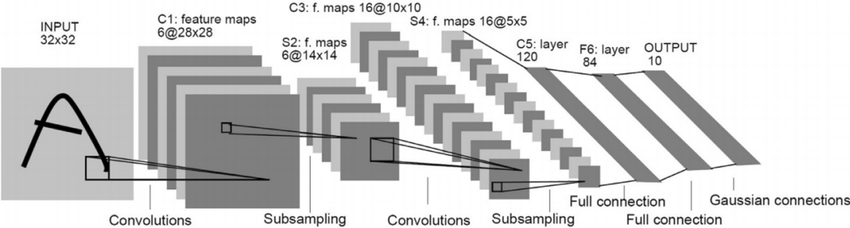

The first CNNs were devised in the late 1980s by Yann LeCun and they were designed to solve the digit recognition task present in the MNIST dataset. It's a simple yet effective architecture that demonstrates the main concepts that still underly many more advanced CNN architectures today. Here we'll replicate the structure of LeNet up to the fully connected `fc2` layer. The latent representation in this layer is 84 dimensional. We'll add various decoder heads and bottleneck layers to this core architecture (sometimes called a *backbone*) and then we will train on different objectives (cost functions), and we will see how the representations change.

In [12]:
LATENT_DIM = 84

class ConvNeuralNet(nn.Module):

    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, LATENT_DIM)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

### Preparing the data

In [13]:
with contextlib.redirect_stdout(io.StringIO()):

    # Define a transformation pipeline for the MNIST dataset
    mnist_transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize the images to 32x32 pixels
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))  # Normalize the images with mean and standard deviation
    ])

    # Load the MNIST training dataset with transformations applied
    train_val_dataset = torchvision.datasets.MNIST(
        root='./data',  # Directory to store/load the data
        train=True,  # Specify to load the training set
        transform=mnist_transform,  # Apply the transformation pipeline defined earlier
        download=True  # Download the dataset if it's not already present
    )

    # Load the MNIST test dataset with transformations applied
    test_dataset = torchvision.datasets.MNIST(
        root='./data',  # Directory to store/load the data
        train=False,  # Specify to load the test set
        transform=mnist_transform,  # Apply the transformation pipeline defined earlier
        download=True  # Download the dataset if it's not already present
    )

    # Split the training dataset into training and validation sets
    train_size = int(0.9 * len(train_val_dataset))  # Calculate the size of the training set (90% of the original)
    val_size = len(train_val_dataset) - train_size  # Calculate the size of the validation set (remaining 10%)
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset=train_val_dataset,  # Original training dataset to split
        lengths=[train_size, val_size]  # Lengths of the resulting splits
    )

    # Split the test dataset into two halves: original and transfer sets
    test_size_original = int(0.5 * len(test_dataset))  # Calculate the size of the original test set (50% of the original)
    test_size_transfer = len(test_dataset) - test_size_original  # Calculate the size of the transfer test set (remaining 50%)
    test_dataset_original, test_dataset_transfer = torch.utils.data.random_split(
        dataset=test_dataset,  # Original test dataset to split
        lengths=[test_size_original, test_size_transfer]  # Lengths of the resulting splits
    )

    # Display the training dataset object
    train_dataset

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.12MB/s]


### Visualizing some samples from the dataset

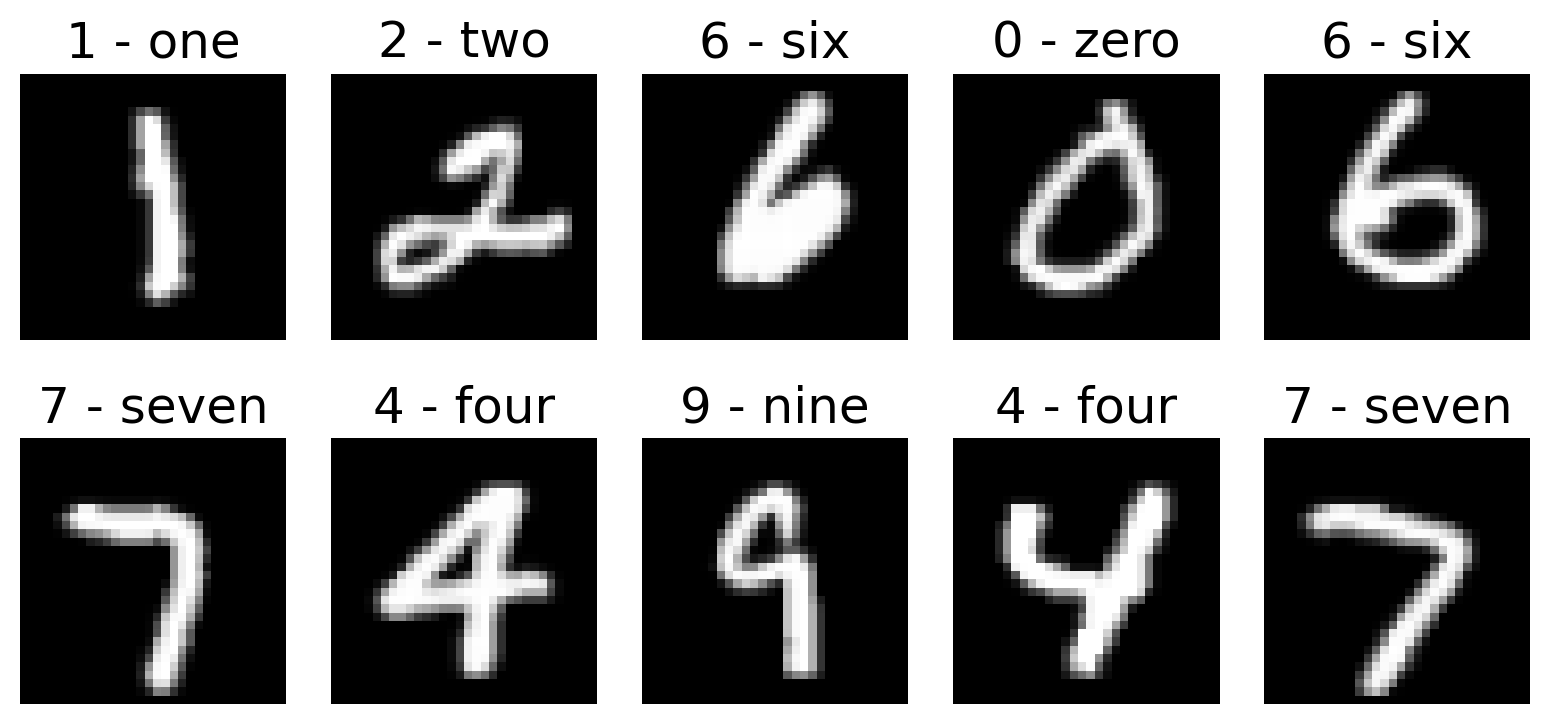

In [15]:
# Retrieve the class names (labels) from the training dataset
class_names = train_dataset.dataset.classes

# Set a manual seed for PyTorch to ensure reproducibility of results
torch.manual_seed(10)

# Create a figure for displaying the images
fig = plt.figure(figsize=(8, 4))  # Set the figure size to 8x4 inches
rows, cols = 2, 5  # Define the number of rows and columns for the subplot grid

# Define the mean and standard deviation used for normalization
mean = 0.1307
std = 0.3081

# Loop to display a grid of sample images from the training dataset
for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_ind]
    img_tensor = img * std + mean
    img_tensor = img_tensor / 2 + 0.5
    img_np = np.squeeze(img_tensor.numpy())
    fig.add_subplot(rows, cols, i)
    plt.imshow(img_np, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

### Preparing the data loaders

In [14]:
batch_size = 32

# Create a DataLoader for the training dataset
train_loader = DataLoader(
    dataset=train_dataset,  # The dataset to load data from
    batch_size=batch_size,  # The number of samples per batch
    shuffle=True  # Shuffle the data at every epoch
)

# Create a DataLoader for the validation dataset
val_loader = DataLoader(
    dataset=val_dataset,  # The dataset to load data from
    batch_size=batch_size,  # The number of samples per batch
    shuffle=True  # Shuffle the data at every epoch
)

# Create a DataLoader for the original test dataset
test_loader_original = DataLoader(
    dataset=test_dataset_original,  # The dataset to load data from
    batch_size=batch_size,  # The number of samples per batch
    shuffle=True  # Shuffle the data at every epoch
)

# Create a DataLoader for the transfer test dataset
test_loader_transfer = DataLoader(
    dataset=test_dataset_transfer,  # The dataset to load data from
    batch_size=batch_size,  # The number of samples per batch
    shuffle=True  # Shuffle the data at every epoch
)

In [16]:
# Defining epochs and batch size
epochs_max = 20
batch_size = 32

## Section 1.1: Classification

In this task, we'll train the CNN to classify digits into one of 10 different classes.

### Code exercise 1: Cost Function

#### Training

In this task, we aim to classify hand-written digits from images, where each digit ranges from 0 to 9. To achieve this, we add a classification head to the CNN.

We introduce an output layer Y with 10 nodes, each representing one of the possible digits. The output layer uses the softmax activation function to produce probability scores for each class:

$$p(y=j|x) = \frac{e^{\mu_j}}{\sum_{k=1}^{10} e^{\mu_k}}$$

where $\mu_j = \text{CNN}_j(x)$ is the output of the $j^{th}$ node in the output layer.

In [33]:
class ClassificationOutputLayer(nn.Module):

    def __init__(self):
        super(ClassificationOutputLayer, self).__init__()
        self.fc = nn.Linear(LATENT_DIM, 10)

    def forward(self, x):
        x = F.softmax(self.fc(x), dim=1)

        return x

Thus, the network outputs a probability distribution over the 10 possible classes for each input image.

#### Cost Function

To train the network effectively, we implement a cost function based the the concept of **cross-entropy**. The cost function is defined as:

$$\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{10} y_{ij} \log(p(y_{ij}|x_i))$$

where:

* $N$ is the number of samples
* $y_{ij}$ is the true label for the $i^{th}$ sample, encoded as a one-hot vector
* $p(y_{ij}|x_i)$ is the predicted probability of the $j^{th}$ class for the $i^{th}$ sample.

In [34]:
def cost_autoencoder(output, target):
    criterion = nn.MSELoss()
    output_flat = output.view(output.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    cost = criterion(output_flat, target_flat)
    return cost

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_53f79ab6.py)



By implementing this cost function, the model is trained to minimize the difference between the predicted probability distributions and the actual one-hot encoded targets (also a probability distribution, but with all of the weight on a single class).

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Cost_Function")

### Defining the model

We define a CNN model with a classification head to classify the digits.

In [35]:
class ClassificationConvNet(nn.Module):

    def __init__(self, ConvNet, Output):
        super(ClassificationConvNet, self).__init__()
        self.ConvNet = ConvNet
        self.Output = Output

    def forward(self, x):
        conv_intermediate = self.ConvNet(x)
        output = self.Output(conv_intermediate)

        return output

Here, `ConvNet` represents the convolutional part of the network responsible for feature extraction, while `Output` is the classification output layer described earlier and implemented in code. In the slot for `ConvNet`, we will be passing the instantiated object `ConvNeuralNet` (see above) and in the slot for `Output`, we will be passing the instantiated object `ClassificationOutputLayer` (also defined above).

### Training on different dataset sizes

We conduct training experiments with this model on varying dataset sizes (10, 100, 1000, 10000). This approach helps us understand how the model's performance scales with the amount of training data available (sample complexity). Larger datasets typically improve the model's ability to generalize to the test set.

In [36]:
set_seed(42)

# Usage example for classification task
training_points = np.array([10, 100, 1000, 10000])
task_name_classification = "classification"
acc_flag_classification = True
triplet_flag_classification = False
epochs_max_classification = 10

my_epoch_Classification = []
my_train_cost_Classification = [] # Add a list to store training costs
my_val_cost_Classification = [] # Add a list to store val costs
my_test_cost_Classification = [] # Add a list to store test costs
conf_matrices = [] # List to store confusion matrices

for N_train_data in training_points:
    model = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer()).to(device)

    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    # Update the train function call to get training costs
    my_epoch, my_train_cost, my_val_cost, my_test_cost = train(
        model,
        sampled_train_loader,
        sampled_val_loader,
        test_loader_original,
        cost_classification,
        optimizer,
        epochs_max_classification,
        acc_flag_classification,
        triplet_flag_classification,
        task_name_classification,
        N_train_data
    )

    my_epoch_Classification.append(my_epoch)
    my_train_cost_Classification.append(my_train_cost)
    my_val_cost_Classification.append(my_val_cost)
    my_test_cost_Classification.append(my_test_cost)

    # Compute predictions and confusion matrix for the validation set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(sampled_val_loader):
            X, y = X.to(device), y.to(device)
            predictions = model(X)
            _, predicted_classes = torch.max(predictions, 1)
            all_preds.extend(predicted_classes.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrices.append((N_train_data, conf_matrix))  # Store the confusion matrix with the number of training points

    # Compute predictions and confusion matrix for the validation set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(sampled_val_loader):
            X, y = X.to(device), y.to(device)
            predictions = model(X)
            _, predicted_classes = torch.max(predictions, 1)
            all_preds.extend(predicted_classes.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrices.append((N_train_data, conf_matrix))  # Store the confusion matrix with the number of training points

Training epochs:  10%|█         | 1/10 [00:01<00:13,  1.52s/epoch]

Epoch: 1| Train cost:  2.30030| Train acc:  0.20000| Val cost:  2.30344| Val acc:  0.10000| Test cost:  2.30159| Test acc:  0.09972
Saving the model: models/ConvNet_classification_10_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:03<00:12,  1.56s/epoch]

Epoch: 2| Train cost:  2.29476| Train acc:  0.20000| Val cost:  2.30213| Val acc:  0.10000| Test cost:  2.30087| Test acc:  0.10171
Saving the model: models/ConvNet_classification_10_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:04<00:11,  1.71s/epoch]

Epoch: 3| Train cost:  2.28905| Train acc:  0.30000| Val cost:  2.30085| Val acc:  0.10000| Test cost:  2.30005| Test acc:  0.13256
Saving the model: models/ConvNet_classification_10_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:06<00:09,  1.57s/epoch]

Epoch: 4| Train cost:  2.28218| Train acc:  0.40000| Val cost:  2.29938| Val acc:  0.10000| Test cost:  2.29908| Test acc:  0.15545
Saving the model: models/ConvNet_classification_10_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:07<00:07,  1.50s/epoch]

Epoch: 5| Train cost:  2.27340| Train acc:  0.40000| Val cost:  2.29780| Val acc:  0.10000| Test cost:  2.29780| Test acc:  0.16939
Saving the model: models/ConvNet_classification_10_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:09<00:05,  1.45s/epoch]

Epoch: 6| Train cost:  2.26213| Train acc:  0.40000| Val cost:  2.29630| Val acc:  0.13333| Test cost:  2.29618| Test acc:  0.18312
Saving the model: models/ConvNet_classification_10_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:10<00:04,  1.42s/epoch]

Epoch: 7| Train cost:  2.24699| Train acc:  0.40000| Val cost:  2.29527| Val acc:  0.13333| Test cost:  2.29392| Test acc:  0.18710
Saving the model: models/ConvNet_classification_10_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:11<00:02,  1.38s/epoch]

Epoch: 8| Train cost:  2.22722| Train acc:  0.40000| Val cost:  2.29514| Val acc:  0.13333| Test cost:  2.29166| Test acc:  0.18869
Saving the model: models/ConvNet_classification_10_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:13<00:01,  1.37s/epoch]

Epoch: 9| Train cost:  2.20304| Train acc:  0.40000| Val cost:  2.29622| Val acc:  0.13333| Test cost:  2.28872| Test acc:  0.18969
Saving the model: models/ConvNet_classification_10_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:14<00:00,  1.45s/epoch]


Epoch: 10| Train cost:  2.17485| Train acc:  0.40000| Val cost:  2.29858| Val acc:  0.13333| Test cost:  2.28652| Test acc:  0.18830
Saving the model: models/ConvNet_classification_10_epoch_10.pth
Elapsed: 14.489094495773315


Training epochs:  10%|█         | 1/10 [00:01<00:17,  2.00s/epoch]

Epoch: 1| Train cost:  2.29918| Train acc:  0.23438| Val cost:  2.29809| Val acc:  0.16667| Test cost:  2.30008| Test acc:  0.09773
Saving the model: models/ConvNet_classification_100_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:03<00:14,  1.75s/epoch]

Epoch: 2| Train cost:  2.28924| Train acc:  0.16406| Val cost:  2.29134| Val acc:  0.16667| Test cost:  2.29702| Test acc:  0.09773
Saving the model: models/ConvNet_classification_100_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:04<00:11,  1.59s/epoch]

Epoch: 3| Train cost:  2.30070| Train acc:  0.10938| Val cost:  2.27972| Val acc:  0.16667| Test cost:  2.29231| Test acc:  0.09893
Saving the model: models/ConvNet_classification_100_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:06<00:09,  1.52s/epoch]

Epoch: 4| Train cost:  2.27172| Train acc:  0.16406| Val cost:  2.27588| Val acc:  0.16667| Test cost:  2.28427| Test acc:  0.09773
Saving the model: models/ConvNet_classification_100_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:07<00:07,  1.47s/epoch]

Epoch: 5| Train cost:  2.22435| Train acc:  0.21875| Val cost:  2.26439| Val acc:  0.16667| Test cost:  2.28069| Test acc:  0.09893
Saving the model: models/ConvNet_classification_100_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:09<00:05,  1.46s/epoch]

Epoch: 6| Train cost:  2.22952| Train acc:  0.16406| Val cost:  2.24435| Val acc:  0.16667| Test cost:  2.26329| Test acc:  0.10231
Saving the model: models/ConvNet_classification_100_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:10<00:04,  1.43s/epoch]

Epoch: 7| Train cost:  2.17872| Train acc:  0.27344| Val cost:  2.24259| Val acc:  0.20000| Test cost:  2.21076| Test acc:  0.27667
Saving the model: models/ConvNet_classification_100_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:12<00:02,  1.43s/epoch]

Epoch: 8| Train cost:  2.13272| Train acc:  0.32031| Val cost:  2.22052| Val acc:  0.20000| Test cost:  2.17802| Test acc:  0.28244
Saving the model: models/ConvNet_classification_100_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:13<00:01,  1.56s/epoch]

Epoch: 9| Train cost:  2.13415| Train acc:  0.33594| Val cost:  2.18109| Val acc:  0.23333| Test cost:  2.15290| Test acc:  0.28842
Saving the model: models/ConvNet_classification_100_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:15<00:00,  1.56s/epoch]


Epoch: 10| Train cost:  2.08263| Train acc:  0.37500| Val cost:  2.17162| Val acc:  0.36667| Test cost:  2.13271| Test acc:  0.37142
Saving the model: models/ConvNet_classification_100_epoch_10.pth
Elapsed: 15.557044267654419


Training epochs:  10%|█         | 1/10 [00:01<00:15,  1.68s/epoch]

Epoch: 1| Train cost:  2.22617| Train acc:  0.26562| Val cost:  2.02302| Val acc:  0.50521| Test cost:  2.02879| Test acc:  0.50159
Saving the model: models/ConvNet_classification_1000_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:03<00:13,  1.72s/epoch]

Epoch: 2| Train cost:  1.86929| Train acc:  0.62109| Val cost:  1.78451| Val acc:  0.70104| Test cost:  1.77927| Test acc:  0.69765
Saving the model: models/ConvNet_classification_1000_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:05<00:11,  1.71s/epoch]

Epoch: 3| Train cost:  1.70143| Train acc:  0.78320| Val cost:  1.70223| Val acc:  0.78385| Test cost:  1.70415| Test acc:  0.76732
Saving the model: models/ConvNet_classification_1000_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:06<00:10,  1.70s/epoch]

Epoch: 4| Train cost:  1.69155| Train acc:  0.77637| Val cost:  1.62157| Val acc:  0.85156| Test cost:  1.66499| Test acc:  0.80474
Saving the model: models/ConvNet_classification_1000_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:08<00:08,  1.72s/epoch]

Epoch: 5| Train cost:  1.63956| Train acc:  0.82715| Val cost:  1.68551| Val acc:  0.78490| Test cost:  1.69539| Test acc:  0.76951
Saving the model: models/ConvNet_classification_1000_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:10<00:07,  1.89s/epoch]

Epoch: 6| Train cost:  1.63192| Train acc:  0.83496| Val cost:  1.64928| Val acc:  0.81042| Test cost:  1.65047| Test acc:  0.81588
Saving the model: models/ConvNet_classification_1000_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:12<00:05,  1.89s/epoch]

Epoch: 7| Train cost:  1.62089| Train acc:  0.84863| Val cost:  1.64214| Val acc:  0.83177| Test cost:  1.62950| Test acc:  0.83698
Saving the model: models/ConvNet_classification_1000_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:14<00:03,  1.84s/epoch]

Epoch: 8| Train cost:  1.60702| Train acc:  0.86133| Val cost:  1.65677| Val acc:  0.79948| Test cost:  1.63553| Test acc:  0.82942
Saving the model: models/ConvNet_classification_1000_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:16<00:01,  1.80s/epoch]

Epoch: 9| Train cost:  1.61611| Train acc:  0.85059| Val cost:  1.63600| Val acc:  0.84271| Test cost:  1.65402| Test acc:  0.81210
Saving the model: models/ConvNet_classification_1000_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:17<00:00,  1.79s/epoch]


Epoch: 10| Train cost:  1.60276| Train acc:  0.85742| Val cost:  1.62140| Val acc:  0.85625| Test cost:  1.61538| Test acc:  0.84753
Saving the model: models/ConvNet_classification_1000_epoch_10.pth
Elapsed: 17.889676570892334


Training epochs:  10%|█         | 1/10 [00:06<00:54,  6.08s/epoch]

Epoch: 1| Train cost:  1.67864| Train acc:  0.80092| Val cost:  1.53726| Val acc:  0.92787| Test cost:  1.52813| Test acc:  0.93770
Saving the model: models/ConvNet_classification_10000_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:11<00:43,  5.43s/epoch]

Epoch: 2| Train cost:  1.52638| Train acc:  0.93890| Val cost:  1.50662| Val acc:  0.95714| Test cost:  1.50651| Test acc:  0.95760
Saving the model: models/ConvNet_classification_10000_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:16<00:37,  5.32s/epoch]

Epoch: 3| Train cost:  1.50839| Train acc:  0.95497| Val cost:  1.50030| Val acc:  0.96394| Test cost:  1.49634| Test acc:  0.96716
Saving the model: models/ConvNet_classification_10000_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:21<00:32,  5.39s/epoch]

Epoch: 4| Train cost:  1.49860| Train acc:  0.96336| Val cost:  1.49918| Val acc:  0.96250| Test cost:  1.49290| Test acc:  0.96955
Saving the model: models/ConvNet_classification_10000_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:26<00:26,  5.28s/epoch]

Epoch: 5| Train cost:  1.49134| Train acc:  0.97075| Val cost:  1.49792| Val acc:  0.96394| Test cost:  1.49308| Test acc:  0.96895
Saving the model: models/ConvNet_classification_10000_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:32<00:21,  5.45s/epoch]

Epoch: 6| Train cost:  1.48702| Train acc:  0.97534| Val cost:  1.50230| Val acc:  0.96126| Test cost:  1.49785| Test acc:  0.96417
Saving the model: models/ConvNet_classification_10000_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:37<00:15,  5.32s/epoch]

Epoch: 7| Train cost:  1.48692| Train acc:  0.97474| Val cost:  1.51743| Val acc:  0.94305| Test cost:  1.51205| Test acc:  0.94944
Saving the model: models/ConvNet_classification_10000_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:43<00:10,  5.47s/epoch]

Epoch: 8| Train cost:  1.48226| Train acc:  0.97993| Val cost:  1.49275| Val acc:  0.96786| Test cost:  1.49131| Test acc:  0.96994
Saving the model: models/ConvNet_classification_10000_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:48<00:05,  5.31s/epoch]

Epoch: 9| Train cost:  1.48301| Train acc:  0.97873| Val cost:  1.49027| Val acc:  0.97054| Test cost:  1.48267| Test acc:  0.97870
Saving the model: models/ConvNet_classification_10000_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:54<00:00,  5.41s/epoch]

Epoch: 10| Train cost:  1.47776| Train acc:  0.98413| Val cost:  1.49655| Val acc:  0.96394| Test cost:  1.49002| Test acc:  0.97134
Saving the model: models/ConvNet_classification_10000_epoch_10.pth
Elapsed: 54.07978653907776


### Test performance

The test performance of the model is evaluated by plotting the test cost across training epochs for different sample sizes.

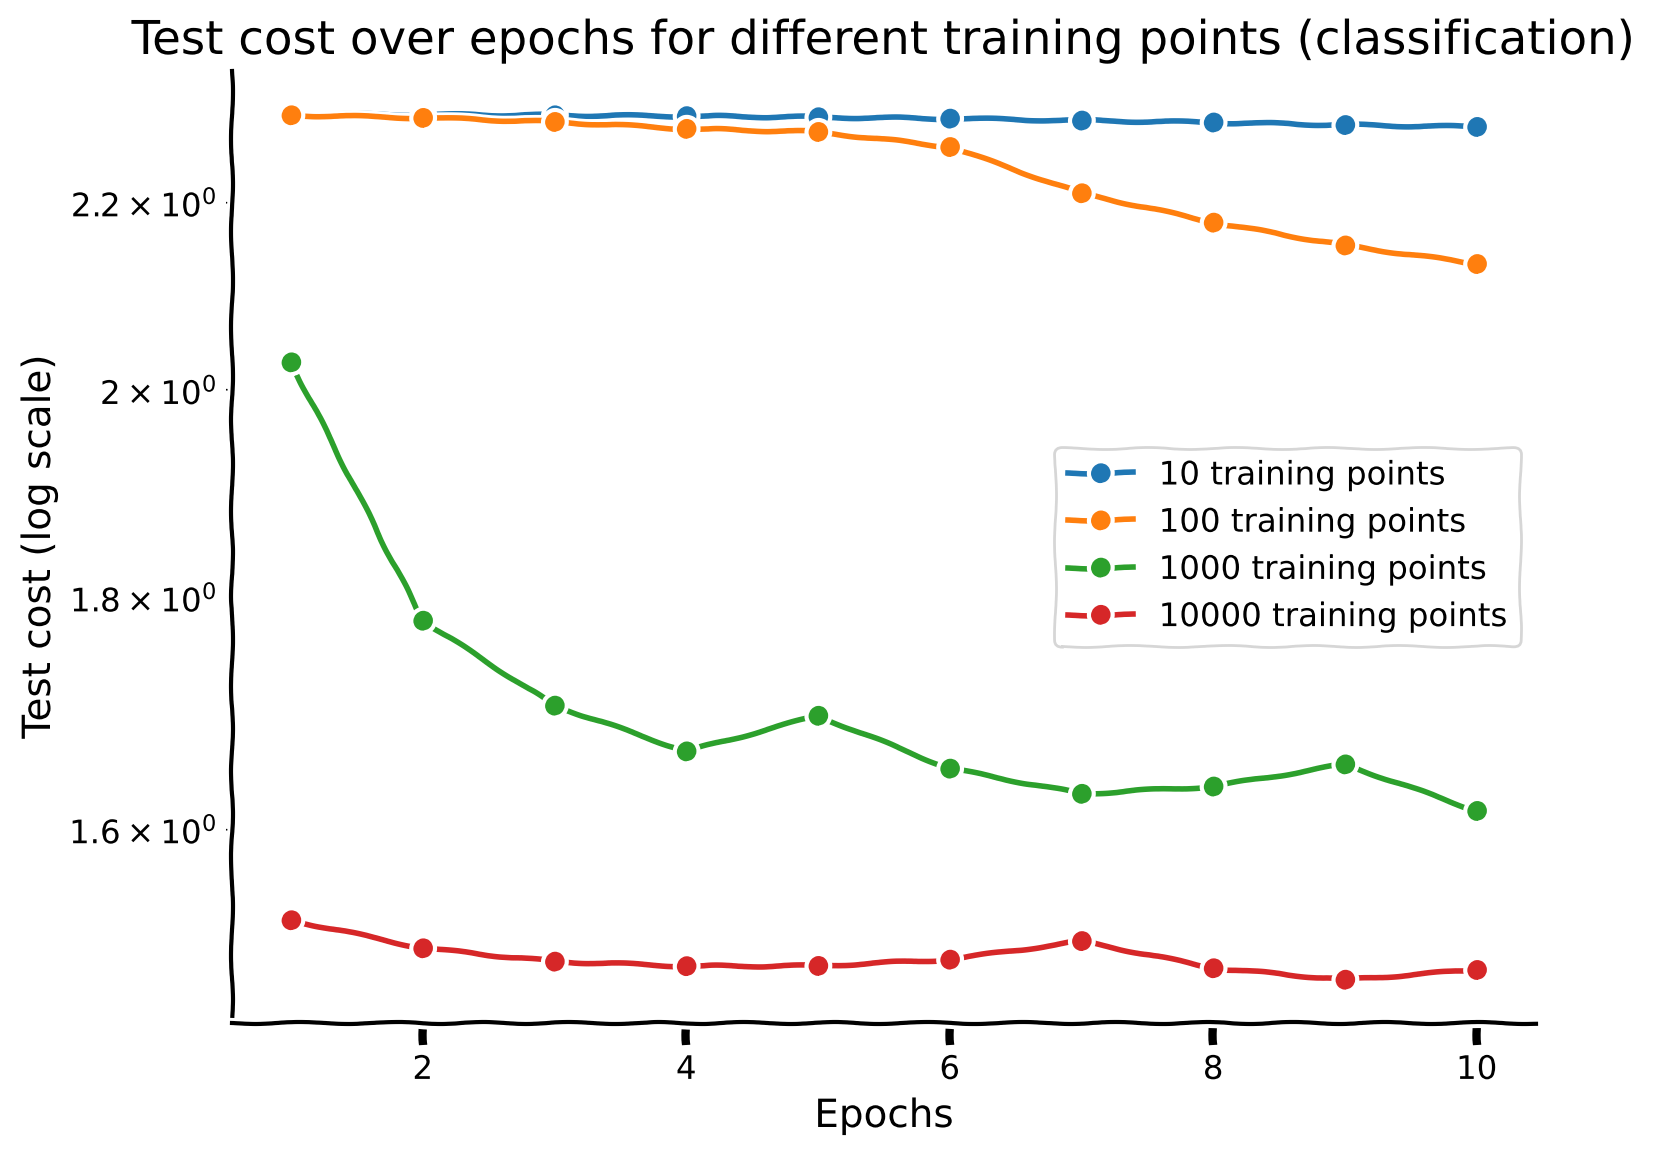

In [37]:
# Create a single plot for all training costs with a logarithmic scale
with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    for i, n in enumerate(training_points):
        epochs = my_epoch_Classification[i]
        test_cost = my_test_cost_Classification[i]
        plt.plot(epochs, test_cost, marker='o', linestyle='-', label=f'{n} training points')

    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs for different training points (classification)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

### Discussion point 1

Now that you have trained your network with different sample sizes, plot the performance on the test dataset for each network across epochs. How does sample size interact with number of training epochs?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_17513eb4.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_1")

## Section 1.2: Regression

After examining the use of network architecture for digit classification, we now transition to a regression task using the same architecture. We are going to pick a very simple output task that is not directly related to the classification or the identification of the digits. In this task, given an image of a handwritten digit, our objective is to predict the number of pixels that are 'ON' (i.e., pixel values greater than 0.5). This can be achieved by the network performing operations similar to the simple addition of pixels (though it might still take time and data for the network to find this simple solution). Thus, we don't expect that the network will learn rich representations that are useful for other tasks, such as classification.

### Task objective

This regression task, while relatively simple as it involves summing pixel values, serves to illustrate how well a Convolutional Neural Network (CNN) can adapt to learning a continuous output instead of discrete class labels.

### Output layer

The output layer for this regression task consists of a single node that predicts the number of 'ON' pixels in the image. This necessitates a different cost function compared to the classification task.

In [38]:
class RegressionOutputLayer(nn.Module):

    def __init__(self):
        super(RegressionOutputLayer, self).__init__()
        self.fc = nn.Linear(LATENT_DIM, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

Here, `RegressionOutputLayer` outputs a single continuous value.

### Code exercise 2: Cost function

Here we implement the mean squared error (MSE) loss, which measures the average squared difference between the predicted and actual pixel values:

$$\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \mu_i)^2$$

where:

- $N$ is the number of sample images
- $y_i$ is the true label for the $i^{th}$ sample, the number of "ON" pixels
- $\mu_i = \text{CNN}(x_i)$ is the output of the model for the $i^{th}$ sample image

In [39]:

def cost_regression(output, target):
    criterion = nn.MSELoss()
    cost = criterion(output, target)
    return cost

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_5ddb1f2c.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Cost_Function_2")

This cost function computes the MSE loss between the predicted number of 'ON' pixels and the actual count of 'ON' pixels in the image, guiding the model to make accurate continuous predictions.

### Training

We train the network on varying dataset sizes (10, 100, 1000, 10000) to observe the impact of sample size on the model's performance.

In [40]:
class RegressionConvNet(nn.Module):

    def __init__(self, ConvNet, Output):
        super(RegressionConvNet, self).__init__()
        self.ConvNet = ConvNet
        self.Output = Output

    def forward(self, x):
        conv_intermediate = self.ConvNet(x)
        output = self.Output(conv_intermediate)

        return output

The RegressionConvNet integrates the convolutional feature extraction network with the regression output layer.

### Dataset preparation

We adapt the MNIST dataset for the regression task by computing the number of 'ON' pixels for each image.

In [41]:
class RegressionMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.dataset = mnist_dataset.dataset

    def __getitem__(self, index):
        X, _ = self.dataset[index]
        updated_label = torch.sum(X > 0.0).float() / X.shape[-1] ** 2 - 0.1307
        return X, updated_label

    def __len__(self):
        return len(self.dataset)

This custom `Dataset` class transforms the images and computes the target values required for our regression task.

### Model training and evaluation

We initialize datasets and data loaders for the regression task, and define functions to evaluate models across different sample sizes.

In [42]:
set_seed(42)

training_points = np.array([10, 100, 1000, 10000])
task_name_regression = "regression"
acc_flag = False
triplet_flag = False
epochs_max_regression = 10

my_epoch_Regression = []
my_train_cost_Regression = []
my_val_cost_Regression = []
my_test_cost_Regression = []

train_dataset_regression = RegressionMNIST(train_dataset)
val_dataset_regression = RegressionMNIST(val_dataset)
test_dataset_original_regression = RegressionMNIST(test_dataset_original)
test_loader_original_regression = torch.utils.data.DataLoader(dataset = test_dataset_original_regression,
                                           batch_size = batch_size,
                                           shuffle = True)

for N_train_data in training_points:
    model = RegressionConvNet(ConvNeuralNet(), RegressionOutputLayer()).to(device)

    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset_regression, val_dataset_regression, batch_size, N_train_data)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    my_epoch, my_train_cost, my_val_cost, my_test_cost = train(model, sampled_train_loader, sampled_val_loader, test_loader_original_regression, cost_regression, optimizer, epochs_max_regression, acc_flag, triplet_flag, task_name_regression, N_train_data)
    my_epoch_Regression.append(my_epoch)
    my_train_cost_Regression.append(my_train_cost)  # Append the training costs
    my_val_cost_Regression.append(my_val_cost)  # Append the val costs
    my_test_cost_Regression.append(my_test_cost)  # Append the test costs

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please 

Epoch: 1| Train cost:  0.00267| Val cost:  0.02717| Test cost:  0.02624|
Saving the model: models/ConvNet_regression_10_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:06<00:27,  3.43s/epoch]

Epoch: 2| Train cost:  0.01898| Val cost:  0.00730| Test cost:  0.00691|
Saving the model: models/ConvNet_regression_10_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:11<00:26,  3.76s/epoch]

Epoch: 3| Train cost:  0.00361| Val cost:  0.00320| Test cost:  0.00301|
Saving the model: models/ConvNet_regression_10_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:14<00:21,  3.61s/epoch]

Epoch: 4| Train cost:  0.00313| Val cost:  0.00431| Test cost:  0.00419|
Saving the model: models/ConvNet_regression_10_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:17<00:17,  3.52s/epoch]

Epoch: 5| Train cost:  0.00580| Val cost:  0.00449| Test cost:  0.00437|
Saving the model: models/ConvNet_regression_10_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:21<00:13,  3.49s/epoch]

Epoch: 6| Train cost:  0.00594| Val cost:  0.00393| Test cost:  0.00380|
Saving the model: models/ConvNet_regression_10_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:25<00:10,  3.65s/epoch]

Epoch: 7| Train cost:  0.00483| Val cost:  0.00340| Test cost:  0.00324|
Saving the model: models/ConvNet_regression_10_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:28<00:07,  3.55s/epoch]

Epoch: 8| Train cost:  0.00368| Val cost:  0.00314| Test cost:  0.00295|
Saving the model: models/ConvNet_regression_10_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:31<00:03,  3.49s/epoch]

Epoch: 9| Train cost:  0.00282| Val cost:  0.00318| Test cost:  0.00295|
Saving the model: models/ConvNet_regression_10_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:35<00:00,  3.60s/epoch]


Epoch: 10| Train cost:  0.00229| Val cost:  0.00346| Test cost:  0.00318|
Saving the model: models/ConvNet_regression_10_epoch_10.pth
Elapsed: 35.9733304977417


Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training epochs:  10%|█         | 1/10 [00:03<00:31,  3.47s/epoch]

Epoch: 1| Train cost:  0.00471| Val cost:  0.00265| Test cost:  0.00336|
Saving the model: models/ConvNet_regression_100_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:06<00:27,  3.45s/epoch]

Epoch: 2| Train cost:  0.00352| Val cost:  0.00230| Test cost:  0.00295|
Saving the model: models/ConvNet_regression_100_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:10<00:25,  3.59s/epoch]

Epoch: 3| Train cost:  0.00279| Val cost:  0.00258| Test cost:  0.00311|
Saving the model: models/ConvNet_regression_100_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:14<00:21,  3.65s/epoch]

Epoch: 4| Train cost:  0.00251| Val cost:  0.00248| Test cost:  0.00302|
Saving the model: models/ConvNet_regression_100_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:17<00:17,  3.57s/epoch]

Epoch: 5| Train cost:  0.00324| Val cost:  0.00231| Test cost:  0.00290|
Saving the model: models/ConvNet_regression_100_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:21<00:14,  3.53s/epoch]

Epoch: 6| Train cost:  0.00261| Val cost:  0.00227| Test cost:  0.00290|
Saving the model: models/ConvNet_regression_100_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:25<00:11,  3.71s/epoch]

Epoch: 7| Train cost:  0.00248| Val cost:  0.00228| Test cost:  0.00291|
Saving the model: models/ConvNet_regression_100_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:28<00:07,  3.61s/epoch]

Epoch: 8| Train cost:  0.00289| Val cost:  0.00228| Test cost:  0.00289|
Saving the model: models/ConvNet_regression_100_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:32<00:03,  3.54s/epoch]

Epoch: 9| Train cost:  0.00256| Val cost:  0.00230| Test cost:  0.00289|
Saving the model: models/ConvNet_regression_100_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:36<00:00,  3.63s/epoch]


Epoch: 10| Train cost:  0.00286| Val cost:  0.00235| Test cost:  0.00292|
Saving the model: models/ConvNet_regression_100_epoch_10.pth
Elapsed: 36.286155462265015


Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training epochs:  10%|█         | 1/10 [00:03<00:34,  3.81s/epoch]

Epoch: 1| Train cost:  0.00513| Val cost:  0.00351| Test cost:  0.00298|
Saving the model: models/ConvNet_regression_1000_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:07<00:30,  3.78s/epoch]

Epoch: 2| Train cost:  0.00303| Val cost:  0.00361| Test cost:  0.00293|
Saving the model: models/ConvNet_regression_1000_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:12<00:28,  4.12s/epoch]

Epoch: 3| Train cost:  0.00303| Val cost:  0.00372| Test cost:  0.00308|
Saving the model: models/ConvNet_regression_1000_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:15<00:24,  4.02s/epoch]

Epoch: 4| Train cost:  0.00310| Val cost:  0.00321| Test cost:  0.00292|
Saving the model: models/ConvNet_regression_1000_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:19<00:19,  3.96s/epoch]

Epoch: 5| Train cost:  0.00306| Val cost:  0.00325| Test cost:  0.00294|
Saving the model: models/ConvNet_regression_1000_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:24<00:16,  4.12s/epoch]

Epoch: 6| Train cost:  0.00331| Val cost:  0.00386| Test cost:  0.00306|
Saving the model: models/ConvNet_regression_1000_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:28<00:12,  4.04s/epoch]

Epoch: 7| Train cost:  0.00305| Val cost:  0.00322| Test cost:  0.00290|
Saving the model: models/ConvNet_regression_1000_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:31<00:07,  3.96s/epoch]

Epoch: 8| Train cost:  0.00304| Val cost:  0.00315| Test cost:  0.00291|
Saving the model: models/ConvNet_regression_1000_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:36<00:04,  4.10s/epoch]

Epoch: 9| Train cost:  0.00305| Val cost:  0.00306| Test cost:  0.00293|
Saving the model: models/ConvNet_regression_1000_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:40<00:00,  4.02s/epoch]


Epoch: 10| Train cost:  0.00295| Val cost:  0.00342| Test cost:  0.00293|
Saving the model: models/ConvNet_regression_1000_epoch_10.pth
Elapsed: 40.226280212402344


Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training epochs:  10%|█         | 1/10 [00:08<01:16,  8.49s/epoch]

Epoch: 1| Train cost:  0.00293| Val cost:  0.00312| Test cost:  0.00294|
Saving the model: models/ConvNet_regression_10000_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:16<01:04,  8.06s/epoch]

Epoch: 2| Train cost:  0.00290| Val cost:  0.00307| Test cost:  0.00291|
Saving the model: models/ConvNet_regression_10000_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:24<00:57,  8.26s/epoch]

Epoch: 3| Train cost:  0.00290| Val cost:  0.00306| Test cost:  0.00289|
Saving the model: models/ConvNet_regression_10000_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:33<00:49,  8.31s/epoch]

Epoch: 4| Train cost:  0.00289| Val cost:  0.00305| Test cost:  0.00288|
Saving the model: models/ConvNet_regression_10000_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:40<00:40,  8.07s/epoch]

Epoch: 5| Train cost:  0.00289| Val cost:  0.00307| Test cost:  0.00289|
Saving the model: models/ConvNet_regression_10000_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:49<00:32,  8.15s/epoch]

Epoch: 6| Train cost:  0.00288| Val cost:  0.00305| Test cost:  0.00288|
Saving the model: models/ConvNet_regression_10000_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:57<00:24,  8.12s/epoch]

Epoch: 7| Train cost:  0.00289| Val cost:  0.00307| Test cost:  0.00289|
Saving the model: models/ConvNet_regression_10000_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [01:04<00:15,  7.98s/epoch]

Epoch: 8| Train cost:  0.00289| Val cost:  0.00308| Test cost:  0.00290|
Saving the model: models/ConvNet_regression_10000_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [01:13<00:08,  8.05s/epoch]

Epoch: 9| Train cost:  0.00289| Val cost:  0.00307| Test cost:  0.00289|
Saving the model: models/ConvNet_regression_10000_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [01:20<00:00,  8.09s/epoch]

Epoch: 10| Train cost:  0.00288| Val cost:  0.00307| Test cost:  0.00289|
Saving the model: models/ConvNet_regression_10000_epoch_10.pth
Elapsed: 80.858078956604


### Discussion point 2

Now that you have trained your network with different sample sizes, plot the test performance for each network across epochs. How does sample size interact with the number of training epochs?

In [ ]:
# Create a single plot for all test costs with a logarithmic scale

with plt.xkcd():
    plt.figure(figsize=(8, 6))  #Set the figure size

    for i, n in enumerate(training_points):
        epochs = my_epoch_Regression[i]
        test_cost = my_test_cost_Regression[i]
        plt.plot(epochs, test_cost, marker='o', linestyle='-', label=f'{n} training points')

    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs for different training points (regression)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_eb15e56d.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_2")

## Section 1.3: Auto-encoder

Now, we extend our network architecture to an unsupervised learning task. Specifically, we aim to develop an autoencoder capable of compressing an image of a handwritten digit into a lower-dimensional representation of size $M$ and then reconstructing the original image with minimal error.

### Autoencoder architecture

An autoencoder consists of three main components: an encoder, a bottleneck layer, and a decoder. The encoder compresses the input into a smaller representation, the bottleneck layer holds this compressed representation, and the decoder reconstructs the original image from this representation.

In [25]:
class Autoencoder(nn.Module):

    def __init__(self, encoder, bottleneck, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.bottleneck = bottleneck
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        bottlenecked = self.bottleneck(encoded)
        decoded = self.decoder(bottlenecked)
        return decoded

In our architecture:

* The encoder will be a CNN
* The bottleneck layer will be a fully connected layer of size $M$.
* The decoder layer will be a deconvolutional neural network, which does the operations of a CNN in reverse: it goes from a dense representation to a low-resolution image, and then upsamples that image in subsequent layers.

### Code exercise 3: Cost Function

We'll use Mean Squared Error (MSE) loss for the autoencoder. This loss function measures the average squared difference between the original and reconstructed images, guiding the network to minimize the reconstruction error.

In [22]:
def cost_autoencoder(output, target):
    criterion = nn.MSELoss()
    output_flat = output.view(output.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    cost = criterion(output_flat, target_flat)
    return cost

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_48232671.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Cost_Function_3")

### Dataset

This custom `Dataset` class prepares the MNIST images for the autoencoder task, applying necessary transformations and using the images themselves as targets for reconstruction.

In [23]:
class AutoencoderMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.dataset = mnist_dataset

    def __getitem__(self, index):
        X, y = self.dataset[index]
        return X, X

    def __len__(self):
        return len(self.dataset)

### Model training and evaluation

We train separate autoencoder networks on different dataset sizes (10, 100, 1000, 10000) to analyze how the amount of data influences the model's performance. The training continues until the validation performance ceases to improve, and test performance is recorded at each epoch.

Note: we also plot here some of the original validation images and how well they were reconstructed by each network after 10 iterations.

Training epochs:  10%|█         | 1/10 [00:02<00:20,  2.26s/epoch]

Epoch: 1| Train cost:  0.82655| Val cost:  0.93275| Test cost:  0.91777|
Saving the model: models/ConvNet_autoencoder_10_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:03<00:14,  1.77s/epoch]

Epoch: 2| Train cost:  0.82601| Val cost:  0.93241| Test cost:  0.91647|
Saving the model: models/ConvNet_autoencoder_10_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:05<00:11,  1.61s/epoch]

Epoch: 3| Train cost:  0.82552| Val cost:  0.93208| Test cost:  0.91641|
Saving the model: models/ConvNet_autoencoder_10_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:07<00:10,  1.80s/epoch]

Epoch: 4| Train cost:  0.82504| Val cost:  0.93175| Test cost:  0.91530|
Saving the model: models/ConvNet_autoencoder_10_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:08<00:08,  1.70s/epoch]

Epoch: 5| Train cost:  0.82457| Val cost:  0.93140| Test cost:  0.91583|
Saving the model: models/ConvNet_autoencoder_10_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:10<00:06,  1.61s/epoch]

Epoch: 6| Train cost:  0.82409| Val cost:  0.93102| Test cost:  0.91561|
Saving the model: models/ConvNet_autoencoder_10_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:11<00:04,  1.55s/epoch]

Epoch: 7| Train cost:  0.82359| Val cost:  0.93060| Test cost:  0.91493|
Saving the model: models/ConvNet_autoencoder_10_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:13<00:03,  1.53s/epoch]

Epoch: 8| Train cost:  0.82304| Val cost:  0.93011| Test cost:  0.91440|
Saving the model: models/ConvNet_autoencoder_10_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:14<00:01,  1.51s/epoch]

Epoch: 9| Train cost:  0.82244| Val cost:  0.92949| Test cost:  0.91384|
Saving the model: models/ConvNet_autoencoder_10_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:15<00:00,  1.60s/epoch]

Epoch: 10| Train cost:  0.82173| Val cost:  0.92875| Test cost:  0.91289|
Saving the model: models/ConvNet_autoencoder_10_epoch_10.pth
Elapsed: 15.983484268188477


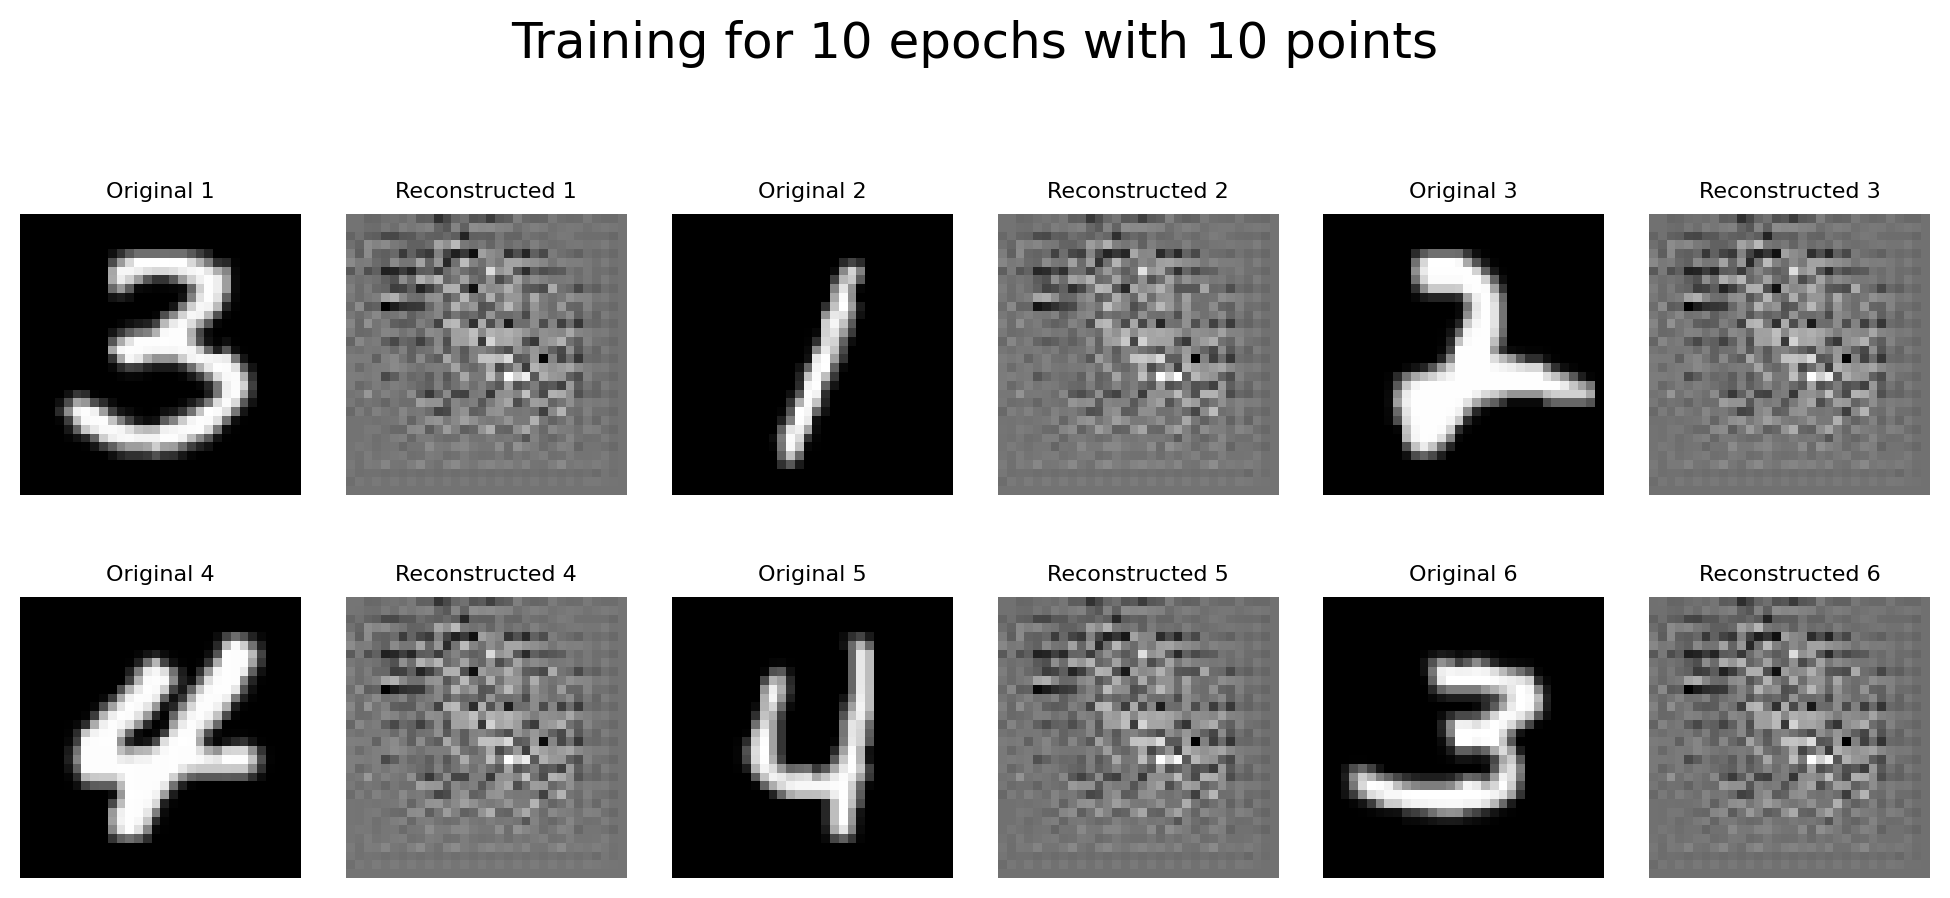

Training epochs:  10%|█         | 1/10 [00:01<00:17,  1.89s/epoch]

Epoch: 1| Train cost:  0.94496| Val cost:  1.09508| Test cost:  0.92759|
Saving the model: models/ConvNet_autoencoder_100_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:03<00:14,  1.87s/epoch]

Epoch: 2| Train cost:  0.84873| Val cost:  1.08896| Test cost:  0.92309|
Saving the model: models/ConvNet_autoencoder_100_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:05<00:12,  1.72s/epoch]

Epoch: 3| Train cost:  0.89585| Val cost:  1.08088| Test cost:  0.91713|
Saving the model: models/ConvNet_autoencoder_100_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:06<00:09,  1.62s/epoch]

Epoch: 4| Train cost:  0.89527| Val cost:  1.06307| Test cost:  0.90104|
Saving the model: models/ConvNet_autoencoder_100_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:08<00:07,  1.59s/epoch]

Epoch: 5| Train cost:  0.90988| Val cost:  0.99760| Test cost:  0.84872|
Saving the model: models/ConvNet_autoencoder_100_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:09<00:06,  1.57s/epoch]

Epoch: 6| Train cost:  0.80134| Val cost:  0.85810| Test cost:  0.75280|
Saving the model: models/ConvNet_autoencoder_100_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:11<00:04,  1.55s/epoch]

Epoch: 7| Train cost:  0.73808| Val cost:  0.82491| Test cost:  0.72001|
Saving the model: models/ConvNet_autoencoder_100_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:12<00:03,  1.54s/epoch]

Epoch: 8| Train cost:  0.67040| Val cost:  0.83882| Test cost:  0.72085|
Saving the model: models/ConvNet_autoencoder_100_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:15<00:01,  1.75s/epoch]

Epoch: 9| Train cost:  0.68790| Val cost:  0.80060| Test cost:  0.69180|
Saving the model: models/ConvNet_autoencoder_100_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:16<00:00,  1.65s/epoch]

Epoch: 10| Train cost:  0.67945| Val cost:  0.77658| Test cost:  0.67812|
Saving the model: models/ConvNet_autoencoder_100_epoch_10.pth
Elapsed: 16.51563262939453


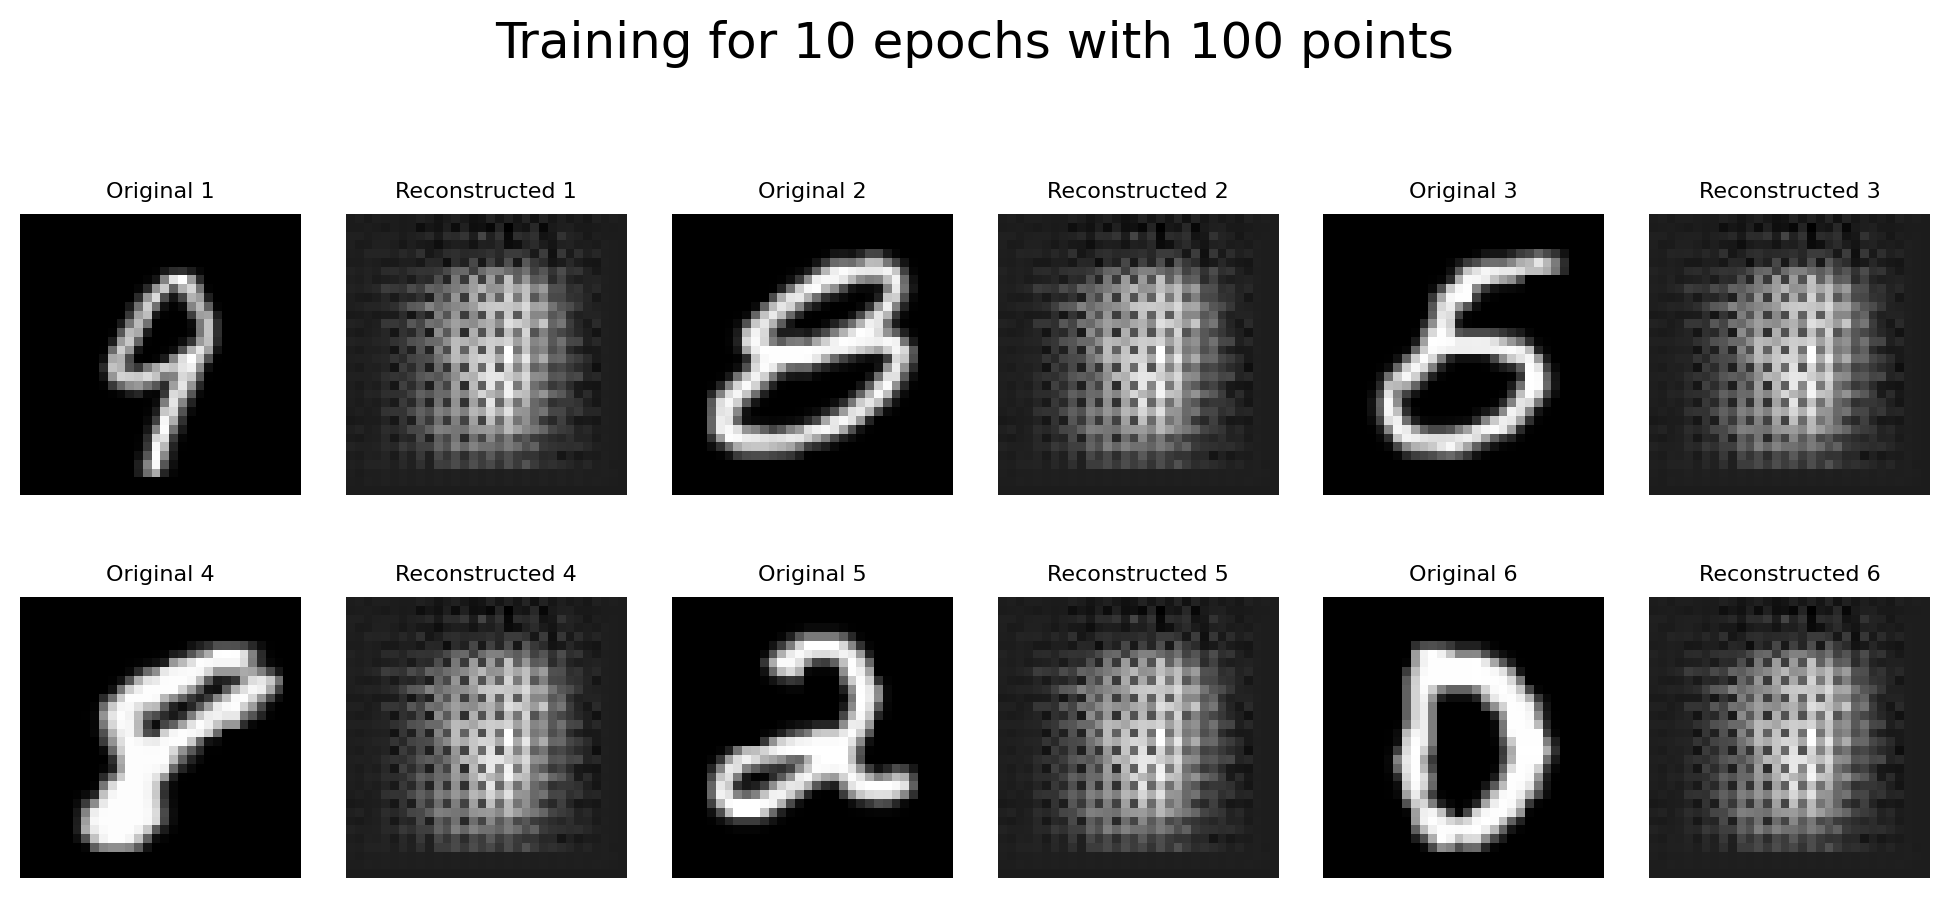

Training epochs:  10%|█         | 1/10 [00:01<00:16,  1.84s/epoch]

Epoch: 1| Train cost:  0.79917| Val cost:  0.67037| Test cost:  0.67448|
Saving the model: models/ConvNet_autoencoder_1000_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:03<00:14,  1.84s/epoch]

Epoch: 2| Train cost:  0.62654| Val cost:  0.61417| Test cost:  0.61077|
Saving the model: models/ConvNet_autoencoder_1000_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:05<00:12,  1.83s/epoch]

Epoch: 3| Train cost:  0.59072| Val cost:  0.59553| Test cost:  0.58791|
Saving the model: models/ConvNet_autoencoder_1000_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:07<00:10,  1.83s/epoch]

Epoch: 4| Train cost:  0.57194| Val cost:  0.58531| Test cost:  0.57860|
Saving the model: models/ConvNet_autoencoder_1000_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:09<00:10,  2.05s/epoch]

Epoch: 5| Train cost:  0.56601| Val cost:  0.56908| Test cost:  0.56927|
Saving the model: models/ConvNet_autoencoder_1000_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:11<00:08,  2.03s/epoch]

Epoch: 6| Train cost:  0.54387| Val cost:  0.54609| Test cost:  0.53281|
Saving the model: models/ConvNet_autoencoder_1000_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:13<00:05,  1.96s/epoch]

Epoch: 7| Train cost:  0.51065| Val cost:  0.52361| Test cost:  0.51234|
Saving the model: models/ConvNet_autoencoder_1000_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:15<00:03,  1.92s/epoch]

Epoch: 8| Train cost:  0.48160| Val cost:  0.47751| Test cost:  0.47160|
Saving the model: models/ConvNet_autoencoder_1000_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:17<00:01,  1.89s/epoch]

Epoch: 9| Train cost:  0.45048| Val cost:  0.44485| Test cost:  0.43959|
Saving the model: models/ConvNet_autoencoder_1000_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:19<00:00,  1.91s/epoch]

Epoch: 10| Train cost:  0.41902| Val cost:  0.42838| Test cost:  0.41966|
Saving the model: models/ConvNet_autoencoder_1000_epoch_10.pth
Elapsed: 19.065836668014526


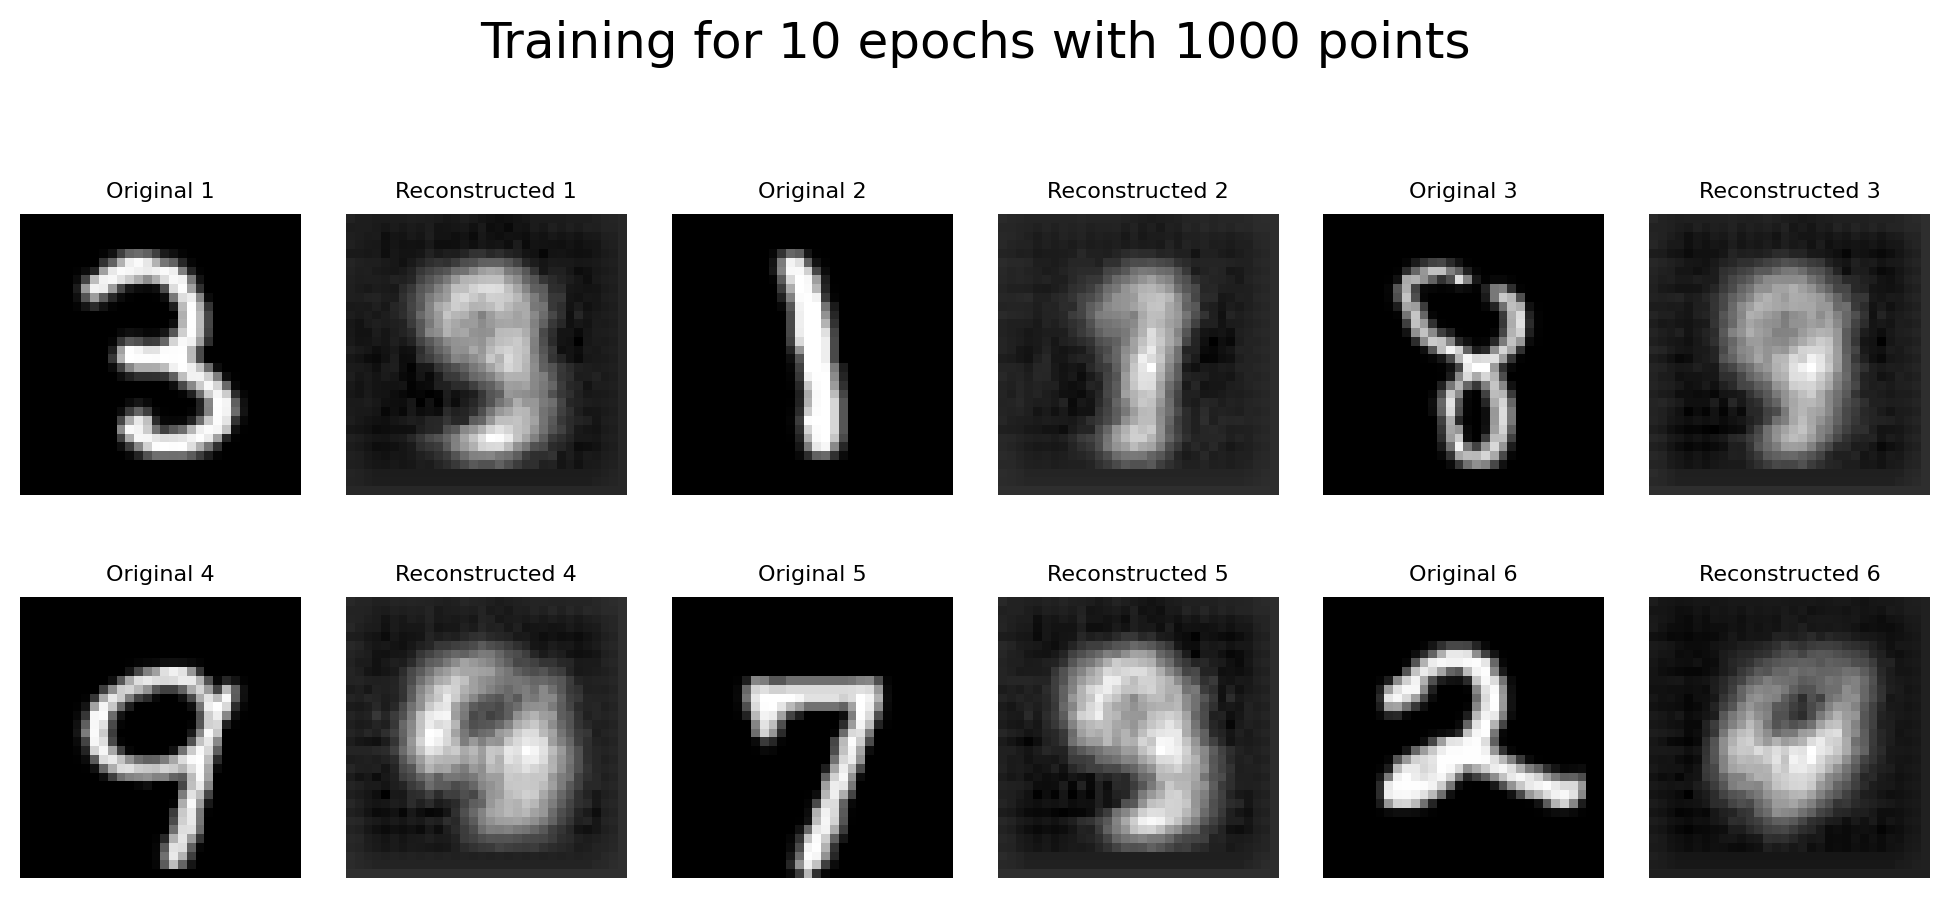

Training epochs:  10%|█         | 1/10 [00:06<00:56,  6.33s/epoch]

Epoch: 1| Train cost:  0.56997| Val cost:  0.43073| Test cost:  0.43521|
Saving the model: models/ConvNet_autoencoder_10000_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:11<00:46,  5.82s/epoch]

Epoch: 2| Train cost:  0.37374| Val cost:  0.32011| Test cost:  0.31869|
Saving the model: models/ConvNet_autoencoder_10000_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:18<00:42,  6.00s/epoch]

Epoch: 3| Train cost:  0.29142| Val cost:  0.26796| Test cost:  0.26339|
Saving the model: models/ConvNet_autoencoder_10000_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:23<00:35,  5.94s/epoch]

Epoch: 4| Train cost:  0.25297| Val cost:  0.24614| Test cost:  0.24293|
Saving the model: models/ConvNet_autoencoder_10000_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:30<00:30,  6.02s/epoch]

Epoch: 5| Train cost:  0.23626| Val cost:  0.23533| Test cost:  0.23192|
Saving the model: models/ConvNet_autoencoder_10000_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:35<00:23,  5.87s/epoch]

Epoch: 6| Train cost:  0.22597| Val cost:  0.22702| Test cost:  0.22410|
Saving the model: models/ConvNet_autoencoder_10000_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:41<00:17,  5.96s/epoch]

Epoch: 7| Train cost:  0.21866| Val cost:  0.21771| Test cost:  0.21544|
Saving the model: models/ConvNet_autoencoder_10000_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:47<00:11,  5.83s/epoch]

Epoch: 8| Train cost:  0.21205| Val cost:  0.21492| Test cost:  0.21204|
Saving the model: models/ConvNet_autoencoder_10000_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:53<00:05,  5.97s/epoch]

Epoch: 9| Train cost:  0.20685| Val cost:  0.21095| Test cost:  0.20859|
Saving the model: models/ConvNet_autoencoder_10000_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:59<00:00,  5.92s/epoch]

Epoch: 10| Train cost:  0.20352| Val cost:  0.20762| Test cost:  0.20492|
Saving the model: models/ConvNet_autoencoder_10000_epoch_10.pth
Elapsed: 59.1900999546051


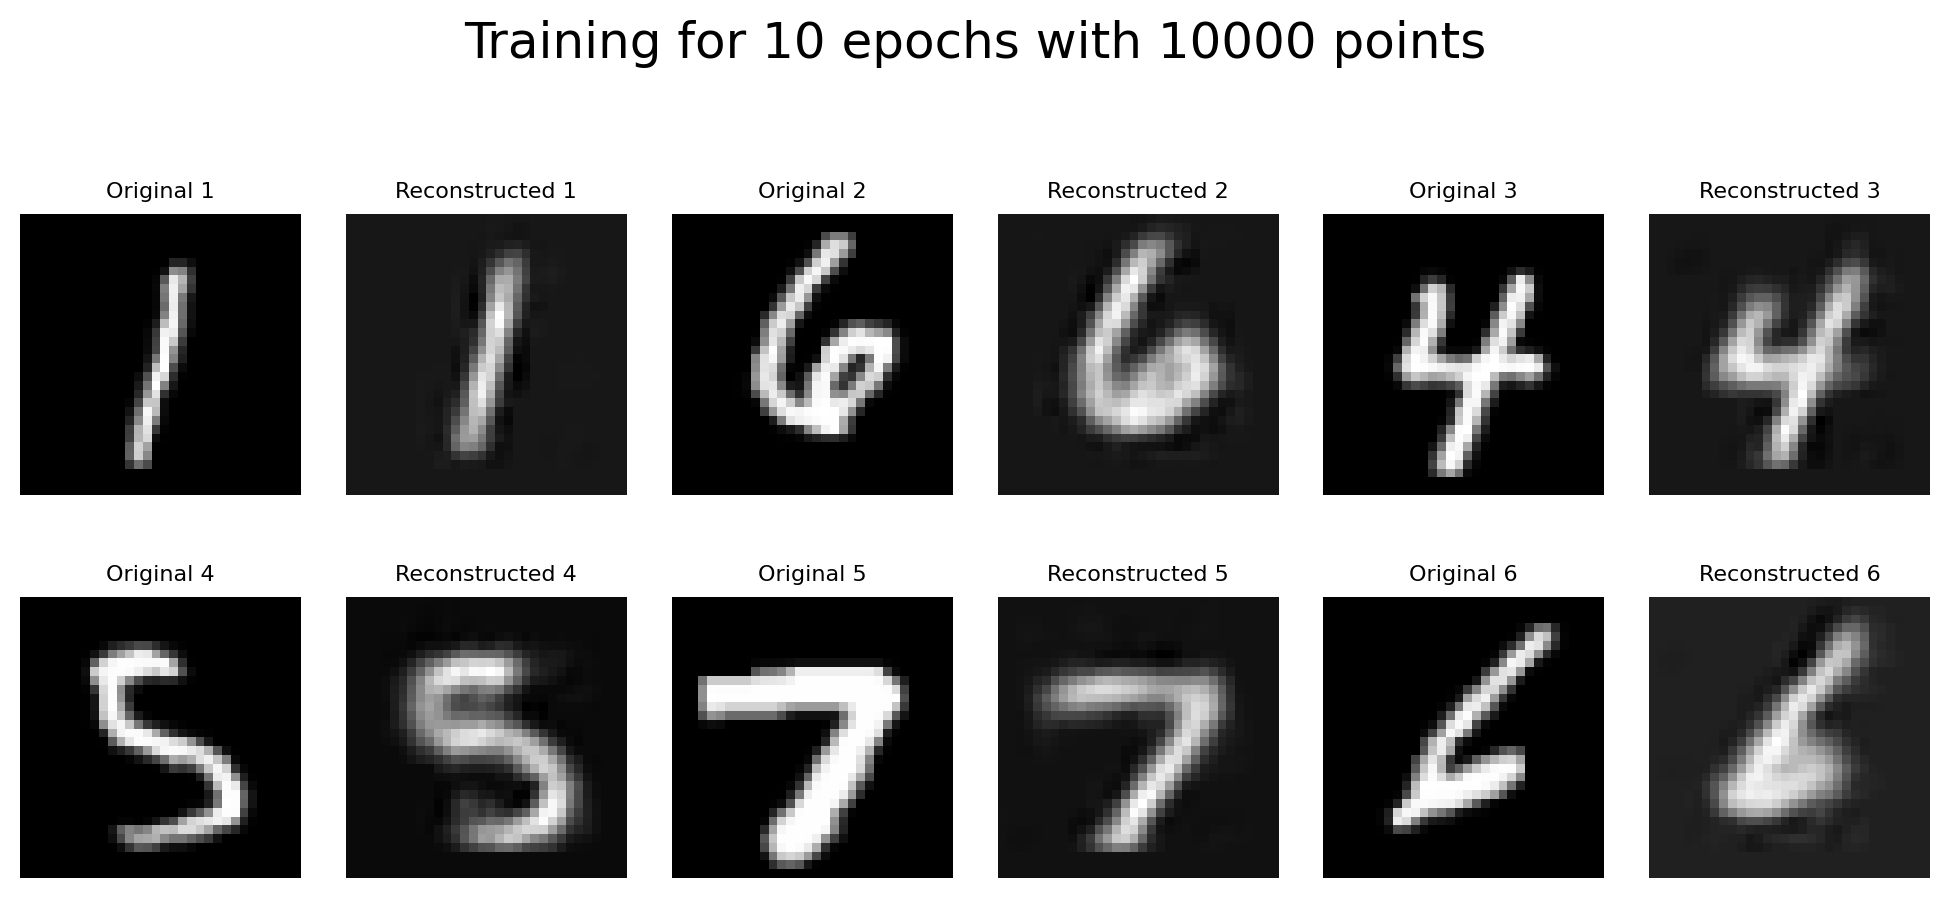

In [26]:
set_seed(42)

# Define constants for autoencoder task
training_points = np.array([10, 100, 1000, 10000])
task_name_autoencoder = "autoencoder"

# Size of the bottleneck. We'll keep this consistent across experiments.
M = 16
acc_flag_autoencoder = False
triplet_flag_autoencoder = False
epochs_max_autoencoder = 10

train_dataset_autoencoder = AutoencoderMNIST(train_dataset)
val_dataset_autoencoder = AutoencoderMNIST(val_dataset)
test_dataset_original_autoencoder = AutoencoderMNIST(test_dataset_original)
test_loader_original_autoencoder = torch.utils.data.DataLoader(
    dataset=test_dataset_original_autoencoder,
    batch_size=batch_size,
    shuffle=True
)

my_epoch_Autoencoder = []
my_train_cost_Autoencoder = []
my_val_cost_Autoencoder = []
my_test_cost_Autoencoder = []
reconstructions = []

for N_train_data in training_points:
    model = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M)).to(device)

    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(
        train_dataset_autoencoder,
        val_dataset_autoencoder,
        batch_size,
        N_train_data
    )
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    my_epoch, my_train_cost, my_val_cost, my_test_cost = train(
        model,
        sampled_train_loader,
        sampled_val_loader,
        test_loader_original_autoencoder,
        cost_autoencoder,
        optimizer,
        epochs_max_autoencoder,
        acc_flag_autoencoder,
        triplet_flag_autoencoder,
        task_name_autoencoder,
        N_train_data
    )
    my_epoch_Autoencoder.append(my_epoch)
    my_train_cost_Autoencoder.append(my_train_cost)
    my_val_cost_Autoencoder.append(my_val_cost)
    my_test_cost_Autoencoder.append(my_test_cost)

    original_images = []
    reconstructed_images = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (X, _) in enumerate(sampled_val_loader):
            if batch_idx == 0:
                X = X.to(device)
                outputs = model(X)
                orig = X.cpu().numpy()
                original_images.extend(orig)
                recon = outputs.cpu().numpy()
                reconstructed_images.extend(recon)
                plot_reconstructions(original_images, reconstructed_images, N_train_data, epochs_max_autoencoder)
                break

    reconstructions.append((N_train_data, original_images, reconstructed_images))

### Discussion point 3

- Plot the performance of the network across epochs. What's the relationship between sample size and iteration complexity?
- What do you think of the images plotted above? Does the autoencoding task require more or less data than the two previous tasks (classification of digit and regression of number of ON pixels)?


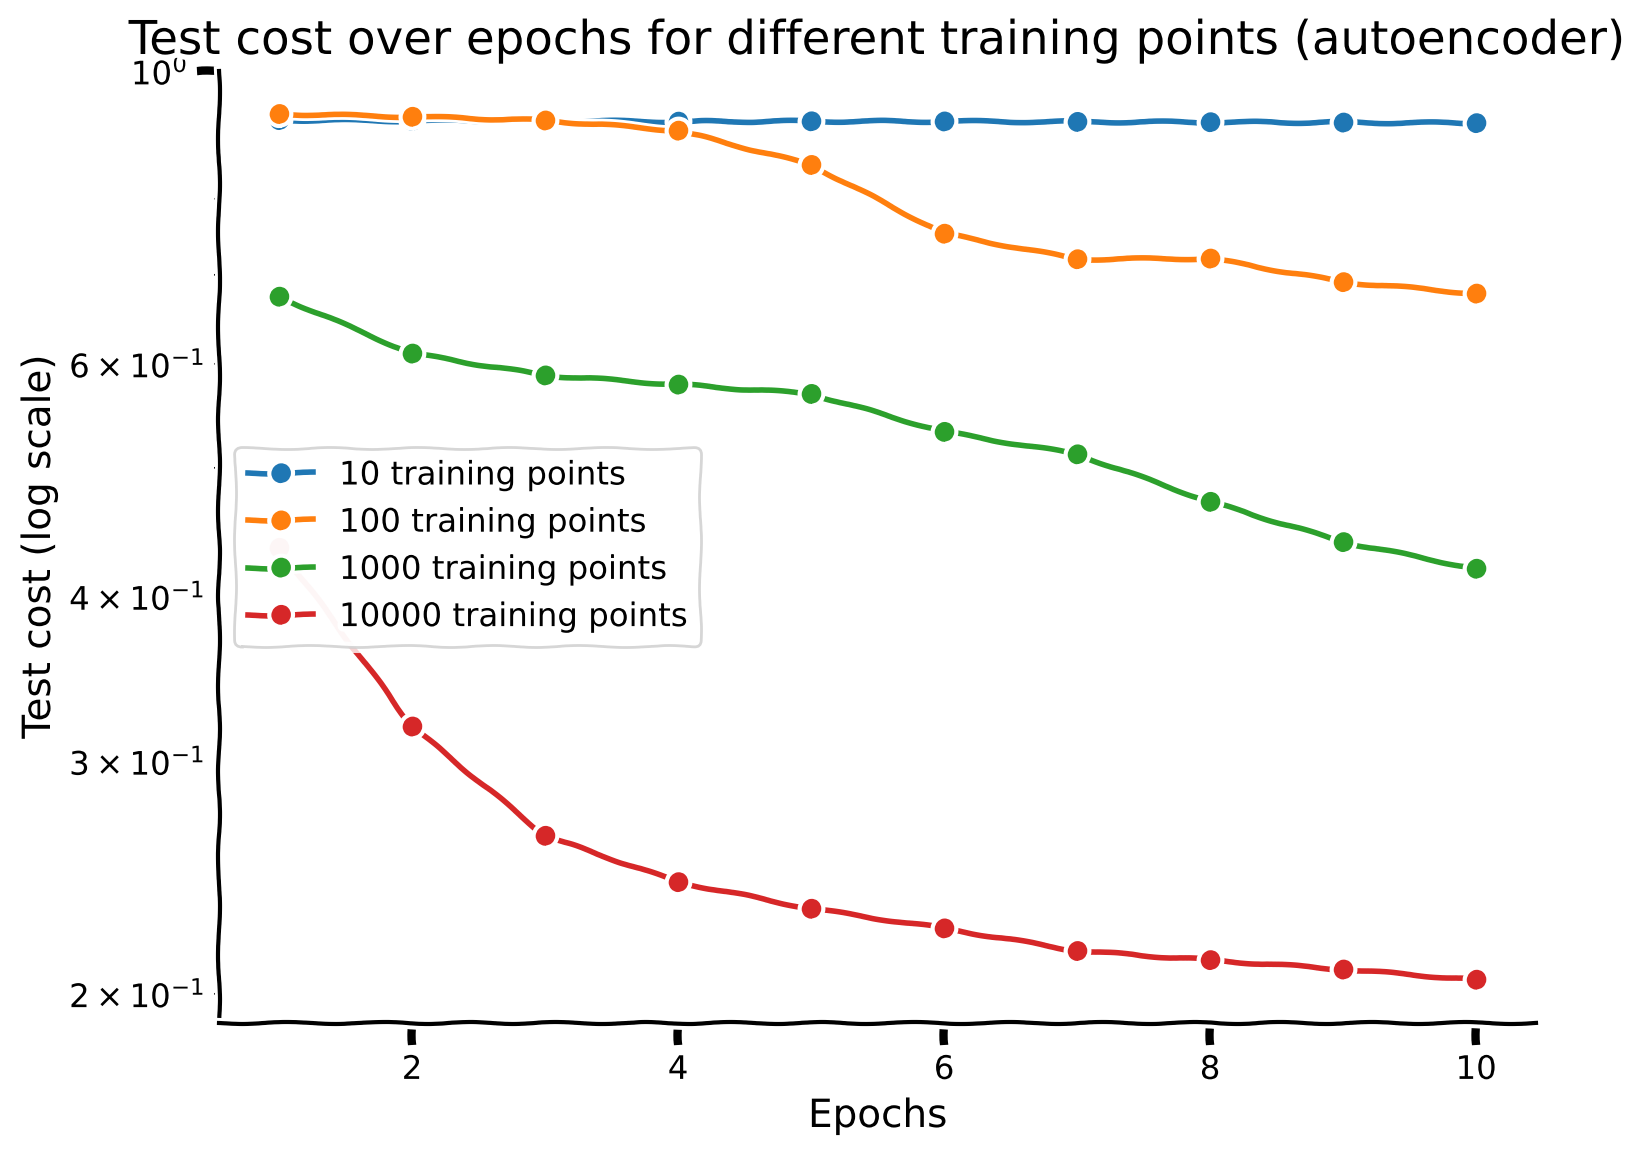

In [27]:
# Create a single plot for all test costs with a logarithmic scale

with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    for i, n in enumerate(training_points):
        epochs = my_epoch_Autoencoder[i]
        test_cost = my_test_cost_Autoencoder[i]
        plt.plot(epochs, test_cost, marker='o', linestyle='-', label=f'{n} training points')

    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs for different training points (autoencoder)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_e18cfe86.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_3")

## Section 1.4: Self-supervised - Inpainting

In this section, we implement a self-supervised task using the same architecture. We define a *patch* of an image to be a small portion of the main image, of a specific patch window size. Given an full image of a handwritten digit with a patch of size $N×N$ masked out, the objective is to reconstruct the image by accurately predicting the pixel values in the masked region. Thus, the network must use the surrounding context to effectively "inpaint" the missing portion.

### Task objective

The task is to build an autoencoder that can fill in missing parts of an image, a process known as **inpainting**. This involves training the model to reconstruct the entire image. Implicitly, the model will predict and reconstruct the masked regions of the image using the contextual information from the non-masked parts.

Important note: this is a simplified inpainting task and not how inpainting is usually defined. Usually, the region to be inpainted is provided as part of the input.

### Random masking

First, we implement a function to randomly mask a part of the image. This function will be used to generate the training data for our inpainting task.

In [17]:
def random_mask(images, mask_size=8):
    """
    Randomly mask an N x N patch in a batch of images.

    Parameters:
    - images: A batch of images as a PyTorch tensor, shape (batch_size, channels, height, width)
    - mask_size: Size of the square mask (N)

    Returns:
    - A new batch of images with the masked portions zeroed out.
    """
    # Clone the images to avoid modifying the original data
    obstructed_images = images.clone()

    batch_size, height, width = images.size()

    for i in range(batch_size):
        # Choose a random location for the mask
        y = np.random.randint(0, height - mask_size)
        x = np.random.randint(0, width - mask_size)

        # Apply the mask by setting the pixel values to 0 (or another value)
        obstructed_images[i, y:y + mask_size, x:x + mask_size] = 0

    return obstructed_images

Here's one example of a masked image.

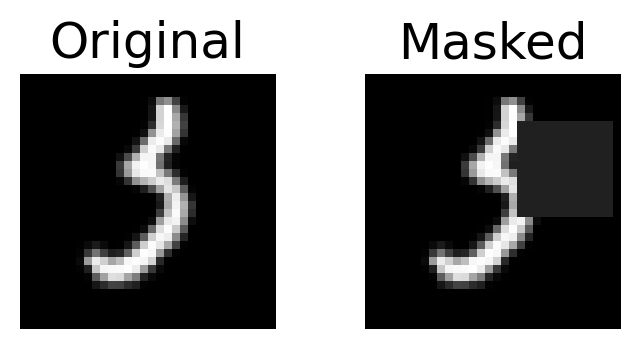

In [18]:
plt.figure(figsize=(4, 2))
ind = 12
img, label = train_dataset[ind]
plt.subplot(121)
plt.imshow(img.numpy().squeeze(), cmap='gray')
plt.title(f"Original")
plt.axis(False)
plt.tight_layout()
plt.subplot(122)
img_masked = random_mask(img, mask_size=12)
plt.imshow(img_masked.numpy().squeeze(), cmap='gray')
plt.title(f"Masked")
plt.axis(False)
plt.tight_layout()

This function randomly places a `N×N` mask in each image by setting the pixel values within this region to zero (black).

### Autoencoder Cost Function

We re-use the same autoencoder architecture as in the previous sections, with an encoder, bottleneck layer, and decoder. We also use the Mean Squared Error (MSE) loss, as it measures the reconstruction error between the predicted and actual pixel values.

### Dataset

This custom `Dataset` class prepares the MNIST images for the inpainting task, applying necessary transformations and adding random masking to create the training data. We specify `mask_size` to be `8` in the `__getitem__` function. This could be specified in the `Dataset` initializer (`__init__`) if we wanted to change it. For now, we will keep it to be `8`.

In [19]:
class InpaintingMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.dataset = mnist_dataset

    def __getitem__(self, index):
        X, y = self.dataset[index]
        obstructed = random_mask(X, mask_size=8)
        return obstructed, X

    def __len__(self):
        return len(self.dataset)

### Model training and evaluation

We train the autoencoder on different dataset sizes (10, 100, 1000, 10000) to evaluate how the sample size affects the model's performance. Training continues until validation performance stops improving, and test performance is recorded at each epoch.

Training epochs:  10%|█         | 1/10 [00:01<00:16,  1.79s/epoch]

Epoch: 1| Train cost:  0.82655| Val cost:  0.93275| Test cost:  0.91777|
Saving the model: models/ConvNet_inpainting_10_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:03<00:14,  1.82s/epoch]

Epoch: 2| Train cost:  0.82601| Val cost:  0.93241| Test cost:  0.91647|
Saving the model: models/ConvNet_inpainting_10_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:05<00:13,  1.86s/epoch]

Epoch: 3| Train cost:  0.82552| Val cost:  0.93208| Test cost:  0.91641|
Saving the model: models/ConvNet_inpainting_10_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:07<00:11,  1.95s/epoch]

Epoch: 4| Train cost:  0.82504| Val cost:  0.93175| Test cost:  0.91530|
Saving the model: models/ConvNet_inpainting_10_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:09<00:10,  2.06s/epoch]

Epoch: 5| Train cost:  0.82457| Val cost:  0.93140| Test cost:  0.91583|
Saving the model: models/ConvNet_inpainting_10_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:11<00:07,  1.99s/epoch]

Epoch: 6| Train cost:  0.82409| Val cost:  0.93103| Test cost:  0.91561|
Saving the model: models/ConvNet_inpainting_10_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:13<00:05,  1.94s/epoch]

Epoch: 7| Train cost:  0.82359| Val cost:  0.93061| Test cost:  0.91493|
Saving the model: models/ConvNet_inpainting_10_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:15<00:03,  1.88s/epoch]

Epoch: 8| Train cost:  0.82305| Val cost:  0.93013| Test cost:  0.91441|
Saving the model: models/ConvNet_inpainting_10_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:17<00:01,  1.87s/epoch]

Epoch: 9| Train cost:  0.82245| Val cost:  0.92950| Test cost:  0.91386|
Saving the model: models/ConvNet_inpainting_10_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:18<00:00,  1.90s/epoch]


Epoch: 10| Train cost:  0.82175| Val cost:  0.92875| Test cost:  0.91291|
Saving the model: models/ConvNet_inpainting_10_epoch_10.pth
Elapsed: 18.9688401222229


Training epochs:  10%|█         | 1/10 [00:02<00:22,  2.48s/epoch]

Epoch: 1| Train cost:  0.94496| Val cost:  1.09508| Test cost:  0.92759|
Saving the model: models/ConvNet_inpainting_100_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:04<00:17,  2.13s/epoch]

Epoch: 2| Train cost:  0.84873| Val cost:  1.08895| Test cost:  0.92308|
Saving the model: models/ConvNet_inpainting_100_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:06<00:14,  2.01s/epoch]

Epoch: 3| Train cost:  0.89581| Val cost:  1.08073| Test cost:  0.91698|
Saving the model: models/ConvNet_inpainting_100_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:08<00:11,  1.95s/epoch]

Epoch: 4| Train cost:  0.89478| Val cost:  1.06119| Test cost:  0.89939|
Saving the model: models/ConvNet_inpainting_100_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:09<00:09,  1.91s/epoch]

Epoch: 5| Train cost:  0.90555| Val cost:  0.98824| Test cost:  0.84085|
Saving the model: models/ConvNet_inpainting_100_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:11<00:07,  1.89s/epoch]

Epoch: 6| Train cost:  0.79199| Val cost:  0.86863| Test cost:  0.76460|
Saving the model: models/ConvNet_inpainting_100_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:14<00:06,  2.09s/epoch]

Epoch: 7| Train cost:  0.73877| Val cost:  0.82494| Test cost:  0.71873|
Saving the model: models/ConvNet_inpainting_100_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:16<00:04,  2.04s/epoch]

Epoch: 8| Train cost:  0.67005| Val cost:  0.83807| Test cost:  0.71953|
Saving the model: models/ConvNet_inpainting_100_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:18<00:01,  1.99s/epoch]

Epoch: 9| Train cost:  0.68633| Val cost:  0.79788| Test cost:  0.69004|
Saving the model: models/ConvNet_inpainting_100_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:20<00:00,  2.01s/epoch]


Epoch: 10| Train cost:  0.67919| Val cost:  0.77445| Test cost:  0.67776|
Saving the model: models/ConvNet_inpainting_100_epoch_10.pth
Elapsed: 20.10047149658203


Training epochs:  10%|█         | 1/10 [00:02<00:21,  2.36s/epoch]

Epoch: 1| Train cost:  0.79506| Val cost:  0.67492| Test cost:  0.67748|
Saving the model: models/ConvNet_inpainting_1000_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:04<00:19,  2.45s/epoch]

Epoch: 2| Train cost:  0.62760| Val cost:  0.61575| Test cost:  0.61304|
Saving the model: models/ConvNet_inpainting_1000_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:07<00:18,  2.61s/epoch]

Epoch: 3| Train cost:  0.59318| Val cost:  0.59748| Test cost:  0.59038|
Saving the model: models/ConvNet_inpainting_1000_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:10<00:15,  2.52s/epoch]

Epoch: 4| Train cost:  0.57481| Val cost:  0.58743| Test cost:  0.58222|
Saving the model: models/ConvNet_inpainting_1000_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:12<00:12,  2.43s/epoch]

Epoch: 5| Train cost:  0.57000| Val cost:  0.57420| Test cost:  0.57505|
Saving the model: models/ConvNet_inpainting_1000_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:14<00:09,  2.39s/epoch]

Epoch: 6| Train cost:  0.56178| Val cost:  0.56104| Test cost:  0.55505|
Saving the model: models/ConvNet_inpainting_1000_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:17<00:07,  2.44s/epoch]

Epoch: 7| Train cost:  0.53646| Val cost:  0.54371| Test cost:  0.53700|
Saving the model: models/ConvNet_inpainting_1000_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:20<00:05,  2.56s/epoch]

Epoch: 8| Train cost:  0.52729| Val cost:  0.53018| Test cost:  0.52515|
Saving the model: models/ConvNet_inpainting_1000_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:22<00:02,  2.48s/epoch]

Epoch: 9| Train cost:  0.51032| Val cost:  0.51108| Test cost:  0.50336|
Saving the model: models/ConvNet_inpainting_1000_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:24<00:00,  2.46s/epoch]


Epoch: 10| Train cost:  0.47384| Val cost:  0.48840| Test cost:  0.47297|
Saving the model: models/ConvNet_inpainting_1000_epoch_10.pth
Elapsed: 24.602747917175293


Training epochs:  10%|█         | 1/10 [00:07<01:07,  7.55s/epoch]

Epoch: 1| Train cost:  0.58185| Val cost:  0.47782| Test cost:  0.48343|
Saving the model: models/ConvNet_inpainting_10000_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:14<00:57,  7.14s/epoch]

Epoch: 2| Train cost:  0.40996| Val cost:  0.34724| Test cost:  0.34307|
Saving the model: models/ConvNet_inpainting_10000_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:22<00:53,  7.60s/epoch]

Epoch: 3| Train cost:  0.31938| Val cost:  0.29985| Test cost:  0.29684|
Saving the model: models/ConvNet_inpainting_10000_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:29<00:44,  7.40s/epoch]

Epoch: 4| Train cost:  0.28117| Val cost:  0.27072| Test cost:  0.26798|
Saving the model: models/ConvNet_inpainting_10000_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:36<00:36,  7.30s/epoch]

Epoch: 5| Train cost:  0.26049| Val cost:  0.25411| Test cost:  0.25209|
Saving the model: models/ConvNet_inpainting_10000_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:44<00:29,  7.34s/epoch]

Epoch: 6| Train cost:  0.24567| Val cost:  0.24189| Test cost:  0.23944|
Saving the model: models/ConvNet_inpainting_10000_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:50<00:21,  7.14s/epoch]

Epoch: 7| Train cost:  0.23277| Val cost:  0.23229| Test cost:  0.22996|
Saving the model: models/ConvNet_inpainting_10000_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:58<00:14,  7.20s/epoch]

Epoch: 8| Train cost:  0.22219| Val cost:  0.22557| Test cost:  0.22239|
Saving the model: models/ConvNet_inpainting_10000_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [01:05<00:07,  7.08s/epoch]

Epoch: 9| Train cost:  0.21473| Val cost:  0.21568| Test cost:  0.21353|
Saving the model: models/ConvNet_inpainting_10000_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [01:12<00:00,  7.27s/epoch]

Epoch: 10| Train cost:  0.20641| Val cost:  0.20716| Test cost:  0.20364|
Saving the model: models/ConvNet_inpainting_10000_epoch_10.pth
Elapsed: 73.00147724151611


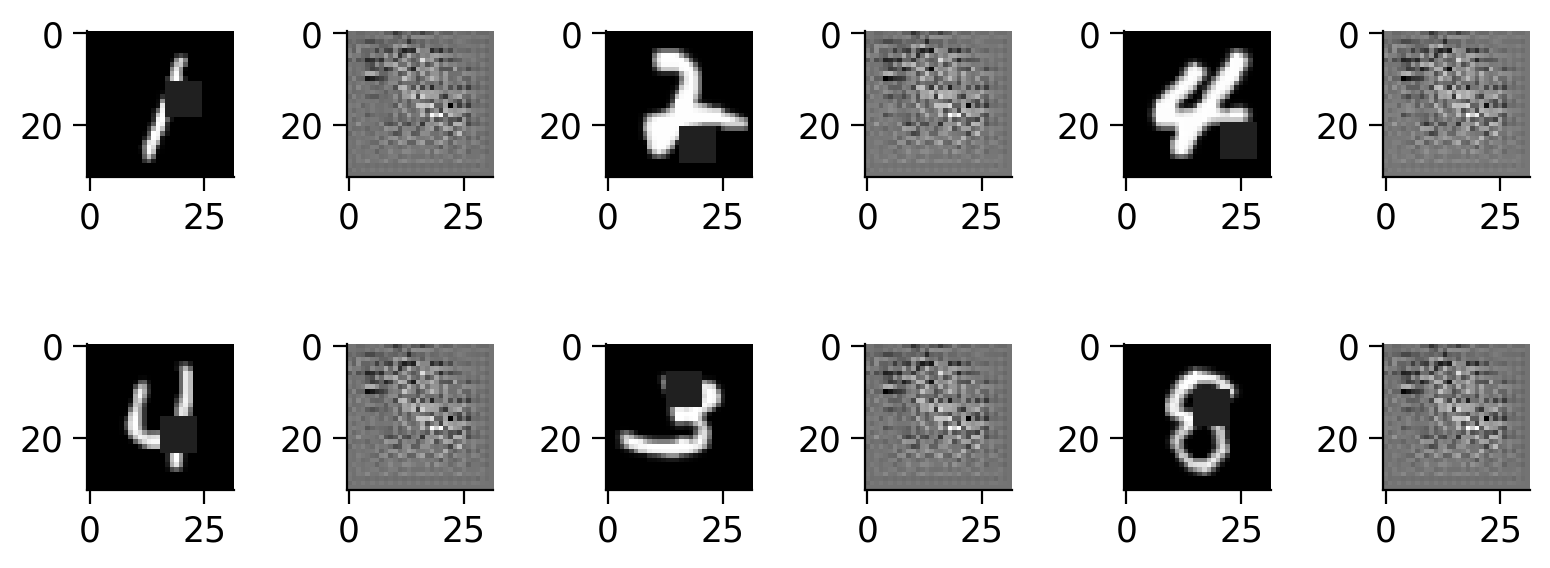

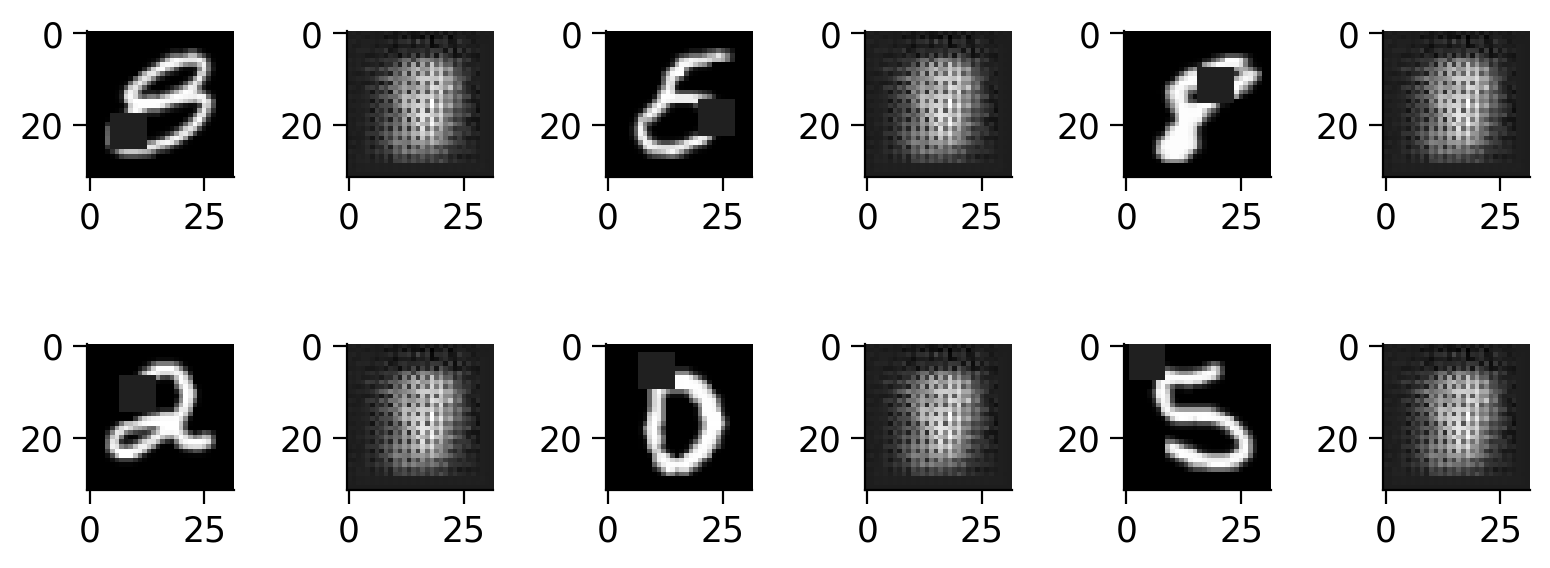

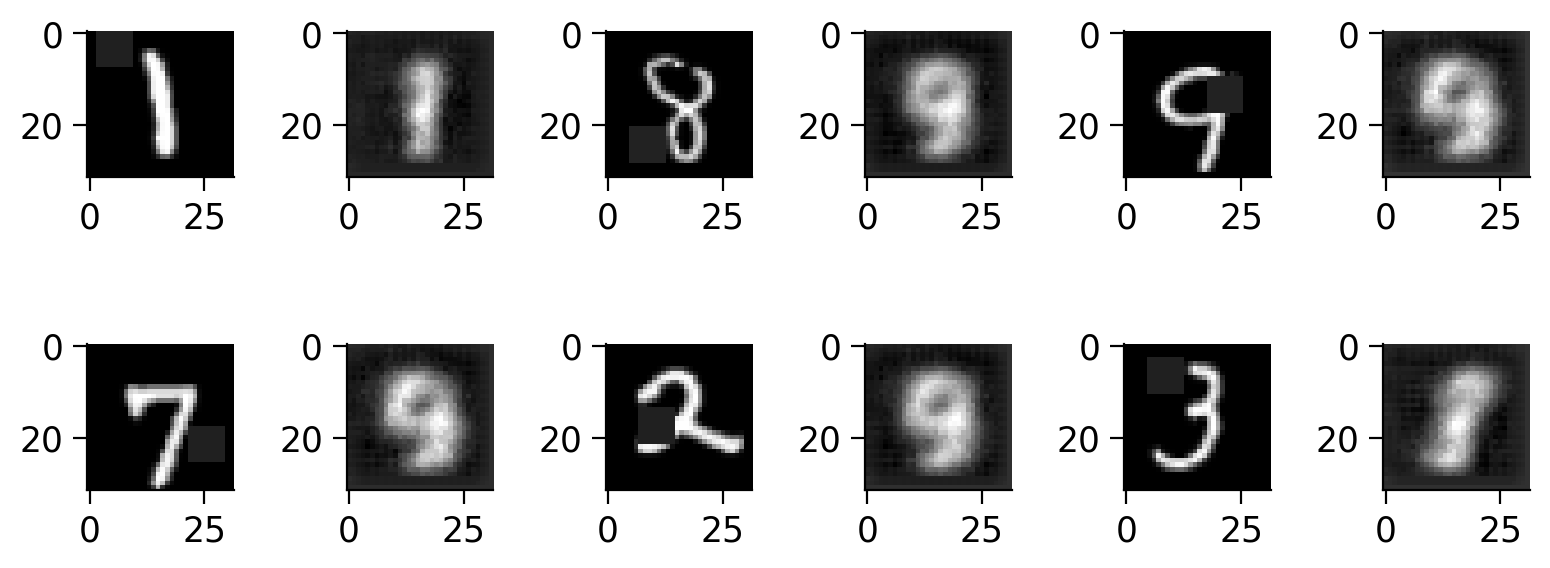

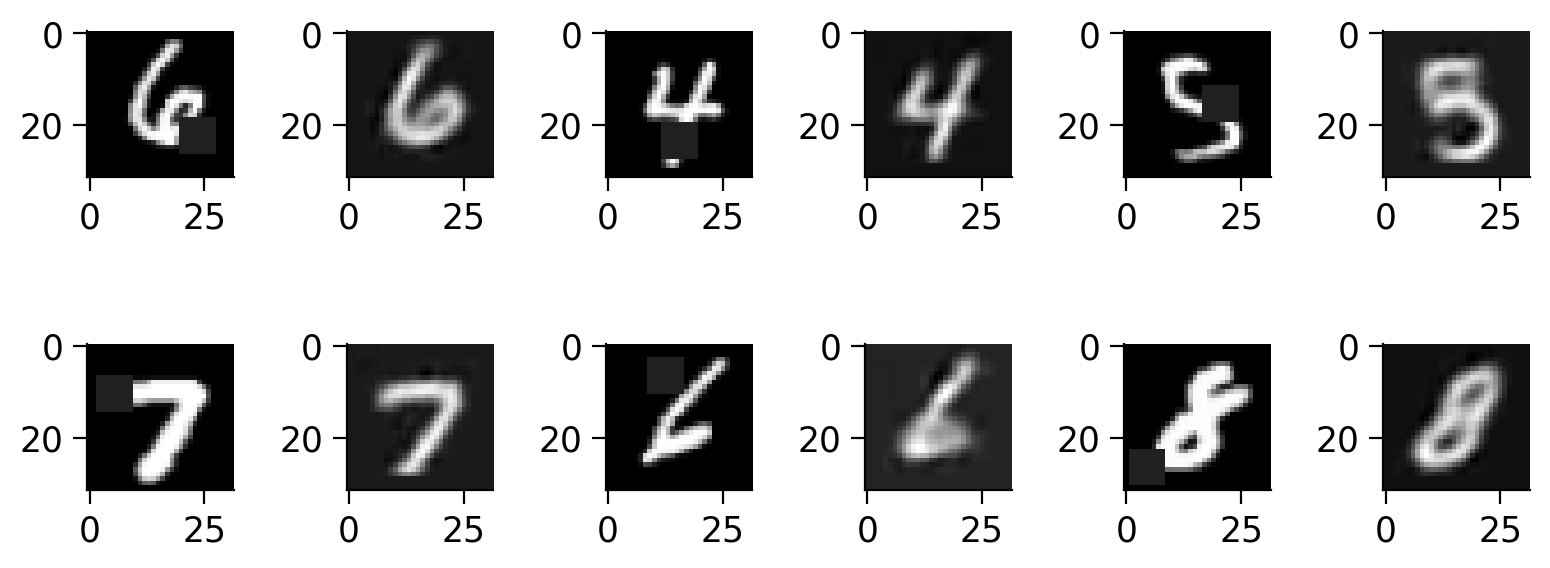

In [28]:
# Define constants
set_seed(42)

training_points = np.array([10, 100, 1000, 10000])
task_name_inpainting = "inpainting"

acc_flag_inpainting = False
triplet_flag_inpainting = False
epochs_max_inpainting = 10

my_epoch_Inpainting = []
my_train_cost_Inpainting = []
my_val_cost_Inpainting = []
my_test_cost_Inpainting = []
reconstructions_inpainting = []

# Create inpainting versions of the training, validation, and test datasets
train_dataset_inpainting = InpaintingMNIST(train_dataset)
val_dataset_inpainting = InpaintingMNIST(val_dataset)
test_dataset_original_inpainting = InpaintingMNIST(test_dataset_original)

# Create a data loader for the inpainting test dataset
test_loader_original_inpainting = torch.utils.data.DataLoader(
    dataset=test_dataset_original_inpainting,
    batch_size=batch_size,
    shuffle=True
)

for N_train_data in training_points:
    model = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M)).to(device)

    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(
        train_dataset_inpainting,
        val_dataset_inpainting,
        batch_size,
        N_train_data
    )
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    # Update the train function call to get training costs
    my_epoch, my_train_cost, my_val_cost, my_test_cost = train(
        model,
        sampled_train_loader,
        sampled_val_loader,
        test_loader_original_inpainting,
        cost_autoencoder,
        optimizer,
        epochs_max_inpainting,
        acc_flag_inpainting,
        triplet_flag_inpainting,
        task_name_inpainting,
        N_train_data
    )

    my_epoch_Inpainting.append(my_epoch)
    my_train_cost_Inpainting.append(my_train_cost)
    my_val_cost_Inpainting.append(my_val_cost)
    my_test_cost_Inpainting.append(my_test_cost)
    original_images = []
    reconstructed_images = []
    model.eval()
    with torch.no_grad():
      for batch_idx, (X, _) in enumerate(sampled_val_loader):
          if batch_idx == 0:  # Only visualize the first batch for simplicity
              X = X.to(device)
              outputs = model(X)
              orig = X.cpu().numpy()
              original_images.extend(orig)
              recon = outputs.cpu().numpy()
              reconstructed_images.extend(recon)
              fig = plt.figure(figsize=(8, 4))
              rows, cols = 2, 6
              image_count = 1
              for i in range(1,(rows*cols),2 ):
                  fig.add_subplot(rows, cols, i)
                  plt.imshow(np.squeeze(orig[image_count]), cmap='gray')
                  fig.add_subplot(rows, cols, i+1)
                  plt.imshow(np.squeeze(recon[image_count]), cmap='gray')
                  image_count+=1
              break
              plt.suptitle("Training for 10 epochs with {} points".format(N_train_data))

    reconstructions_inpainting.append((N_train_data, original_images, reconstructed_images))

### Discussion point 4

- Plot the performance of the model on the test dataset for each network across epochs. What's the relationship between sample size and number of training epochs?
- How do these compare with the other examples above?

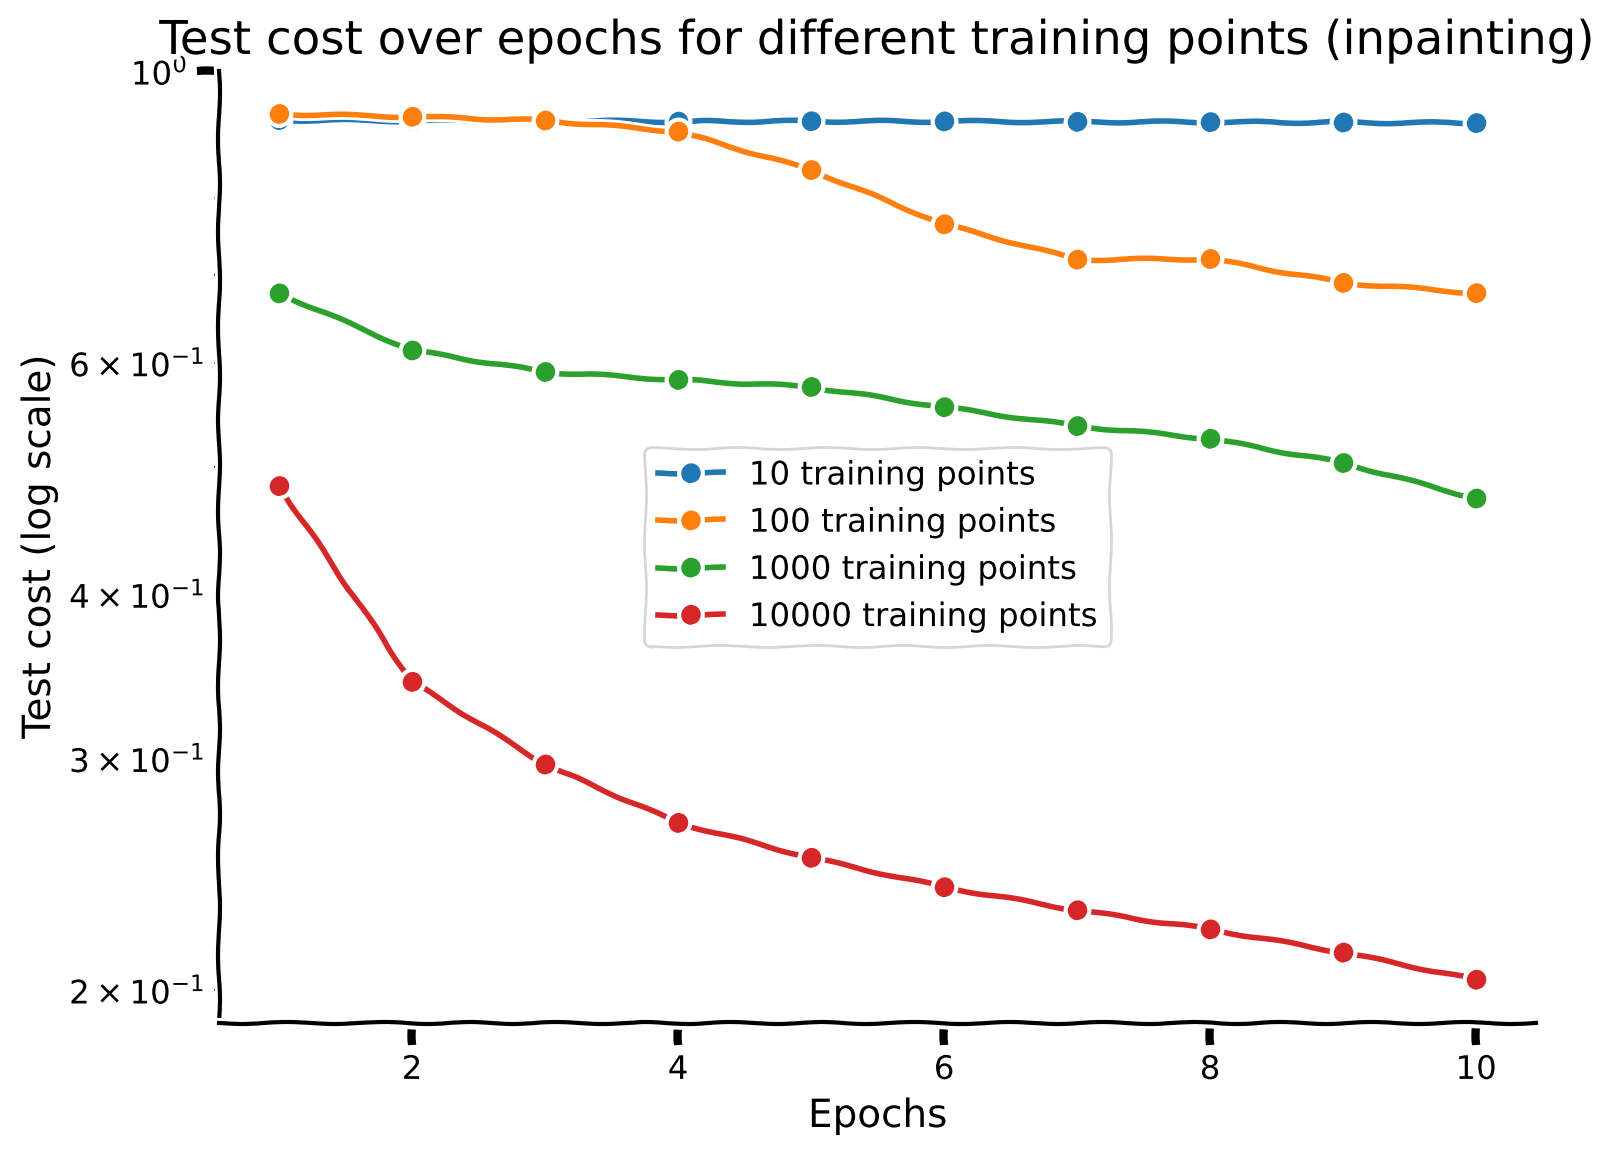

In [29]:
# Create a single plot for all test costs with a logarithmic scale
with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    for i, n in enumerate(training_points):
        epochs = my_epoch_Inpainting[i]
        test_cost = my_test_cost_Inpainting[i]
        plt.plot(epochs, test_cost, marker='o', linestyle='-', label=f'{n} training points')

    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs for different training points (inpainting)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_9836554e.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_5")

---
# Section 2: Generalization of representations

In the first part of this tutorial, we focused on training the same backbone architecture (a CNN) on different tasks, measuring how fast these networks learned in terms of training samples and training epochs. Here, we shift our attention to how well these representations generalize across the different tasks. To make this idea more concrete, think of a model that has learned to identify objects in images. Its early layers will be sensitive to basic blocks and lines, orientations, colors etc. The later layers in the model make use of these more basic shapes and gradually build up more complex patterns. Now, if the task changes to estimating the size of objects found in images, then the representations in those early layers (which capture basic shape information) are very useful to this new task, though some of the later layers will need to be tuned to better carry out the task. This is what we mean when we talk about *generalizable representations* - what learned patterns are useful for multiple (general) tasks - versus representations that are only uniquely relevant for other tasks.

## Section 2.1: Transfer

### Taskonomy

Humans can perform a wide range of tasks. The representations within this system must be general enough to handle multiple tasks, yet specific enough to accommodate differing requirements. We assess the ability of the representations we have learned to perform different tasks by testing generalization from one model to another.

### Transfer learning

We'll measure the ability of a model's representations learned for one task by its ability to transfer to other tasks. For each of the four tasks, we'll use the network trained for the highest number of training points (largest dataset size) and epochs. We define the **source task** to be the task the model was already trained on and the **destination task** to be the one we want to compare via transfer learning. A new test set will be provided for each task. To test generalization, we follow these steps:

1. Create a new network for the destination task using the same architecture as in part 1.
2. Copy the weights for the first N layers from the source network.
3. Freeze these copied weights so they do not change during training.
4. Train the remaining layers on the destination network.

After training, we'll compare the new performance to the original performance to assess transfer performance (generalization) between each pair of networks.

Because we have N=4 different models, we could measure $2*(N-1)*(N-2)=12$ transfer directions. In the interest of time, we'll concentrate on measuring 3 transfer performances from the last 3 models to the classification model.

### Copy weights

We start by defining a function to copy the weights and freeze the layers from the source model to the destination model.

In [30]:
def copy_and_freeze_layers(source_model, destination_model, N):
    """
    Copies the weights of the first N layers from the source model to the
    destination model and freezes them.

    Parameters:
    - source_model: The model from which weights are copied.
    - destination_model: The model to which weights are copied and trained.
    - N: The number of layers to transfer and freeze.

    Note: This function assumes the first N layers are directly accessible and
    does not handle nested modules automatically.
    """

    # Ensure both models are in the same mode (train/eval).
    source_model.eval()
    destination_model.train()

    # Counter to track the number of transferred layers
    transferred_layers = 0

    source_dict = source_model.state_dict()
    dest_dict = destination_model.state_dict()

    # Variables to map between layers
    source_prefix = list(source_dict.keys())[0]
    source_prefix = source_prefix[:source_prefix.find('.')]
    source_dict_names = [s[s.find('.')+1:] for s in list(source_dict.keys())]
    dest_prefix = list(dest_dict.keys())[0]
    dest_prefix = dest_prefix[:dest_prefix.find('.')]
    dest_dict_names = [s[s.find('.')+1:] for s in list(dest_dict.keys())]
    print(dest_dict_names)

    # Transfer layers by matching keys
    for name in source_dict_names:
        if name in dest_dict_names and transferred_layers < N:
            try:
                dest_dict[dest_prefix+'.'+name].copy_(source_dict[source_prefix+'.'+name])
                transferred_layers += 1
                print(f"Copied {name}")
            except Exception as e:
                print(f"Could not copy {name}: {e}")

    # Load the updated state dictionary back to the destination model
    destination_model.load_state_dict(dest_dict)
    print(transferred_layers)
    # Freeze the transferred layers
    for name, param in destination_model.named_parameters():
        if name[name.find('.')+1:] in source_dict_names and transferred_layers > 0:
            print('froze ',name)
            param.requires_grad = False
            transferred_layers -= 1

    print(f"Copied and froze {N} layers.")

## Transfer example 1: regression to classification



We first copy the weights from a regression network to a classification network and freeze them.

In [43]:
MODEL_NAME_SOURCE = "models/ConvNet_regression_10000_epoch_10.pth"
model_source = RegressionConvNet(ConvNeuralNet(), RegressionOutputLayer())

# Load the checkpoint
checkpoint = torch.load(MODEL_NAME_SOURCE)

# Extract the state dictionary from the checkpoint
model_state_dict = checkpoint['model_state_dict']

# Load the state dictionary into the model
model_source.load_state_dict(model_state_dict)

# Define the destination model
model_destination = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())

# Number of layers to transfer and freeze
N = 8

# Transfer and freeze layers
copy_and_freeze_layers(model_source, model_destination, N)

['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc.weight', 'fc.bias']
Copied conv1.weight
Copied conv1.bias
Copied conv2.weight
Copied conv2.bias
Copied fc1.weight
Copied fc1.bias
Copied fc2.weight
Copied fc2.bias
8
froze  ConvNet.conv1.weight
froze  ConvNet.conv1.bias
froze  ConvNet.conv2.weight
froze  ConvNet.conv2.bias
froze  ConvNet.fc1.weight
froze  ConvNet.fc1.bias
froze  ConvNet.fc2.weight
froze  ConvNet.fc2.bias
Copied and froze 8 layers.


#### Training

We train the destination network on the classification task with the transferred weights.

In [44]:
set_seed(42)

batch_size = 64  # Define your batch size

test_loader_transfer = torch.utils.data.DataLoader(dataset = test_dataset_transfer,
                                           batch_size = batch_size,
                                           shuffle = True)
sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data)

# Optimizer
optimizer = optim.Adam(params=model_destination.parameters(), lr=0.001)

# Training parameters
N_train_data = 10000
task_name = "regression_classification"
epochs_max = 10  # Number of epochs
acc_flag = False  # Whether to calculate accuracy
triplet_flag = False  # Whether to use triplet loss

# Call the train_transfer function
my_epoch_transfer1, my_train_cost_transfer1, my_val_cost_transfer1, my_test_cost_transfer1 = train_transfer(
    model_destination,
    sampled_train_loader,
    sampled_val_loader,
    test_loader_transfer,
    cost_classification,
    optimizer,
    epochs_max,
    acc_flag,
    triplet_flag,
    task_name,
    N_train_data
)

Training epochs:  10%|█         | 1/10 [00:04<00:43,  4.83s/epoch]

Epoch: 1| Train cost:  2.30260| Val cost:  2.30234| Test cost:  2.30245|
Saving the model: models/ConvNet_regression_classification_10000_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:08<00:35,  4.44s/epoch]

Epoch: 2| Train cost:  2.30211| Val cost:  2.30194| Test cost:  2.30190|
Saving the model: models/ConvNet_regression_classification_10000_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:13<00:32,  4.68s/epoch]

Epoch: 3| Train cost:  2.30161| Val cost:  2.30166| Test cost:  2.30134|
Saving the model: models/ConvNet_regression_classification_10000_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:18<00:26,  4.49s/epoch]

Epoch: 4| Train cost:  2.30106| Val cost:  2.30128| Test cost:  2.30076|
Saving the model: models/ConvNet_regression_classification_10000_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:22<00:21,  4.40s/epoch]

Epoch: 5| Train cost:  2.30042| Val cost:  2.30081| Test cost:  2.29994|
Saving the model: models/ConvNet_regression_classification_10000_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:27<00:18,  4.57s/epoch]

Epoch: 6| Train cost:  2.29993| Val cost:  2.30030| Test cost:  2.29951|
Saving the model: models/ConvNet_regression_classification_10000_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:31<00:13,  4.44s/epoch]

Epoch: 7| Train cost:  2.29933| Val cost:  2.29939| Test cost:  2.29869|
Saving the model: models/ConvNet_regression_classification_10000_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:35<00:08,  4.41s/epoch]

Epoch: 8| Train cost:  2.29870| Val cost:  2.29979| Test cost:  2.29798|
Saving the model: models/ConvNet_regression_classification_10000_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:40<00:04,  4.52s/epoch]

Epoch: 9| Train cost:  2.29817| Val cost:  2.29874| Test cost:  2.29771|
Saving the model: models/ConvNet_regression_classification_10000_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:44<00:00,  4.48s/epoch]

Epoch: 10| Train cost:  2.29762| Val cost:  2.29795| Test cost:  2.29711|
Saving the model: models/ConvNet_regression_classification_10000_epoch_10.pth
Elapsed: 44.807878494262695


We compare the performance of the transferred model with the original network.

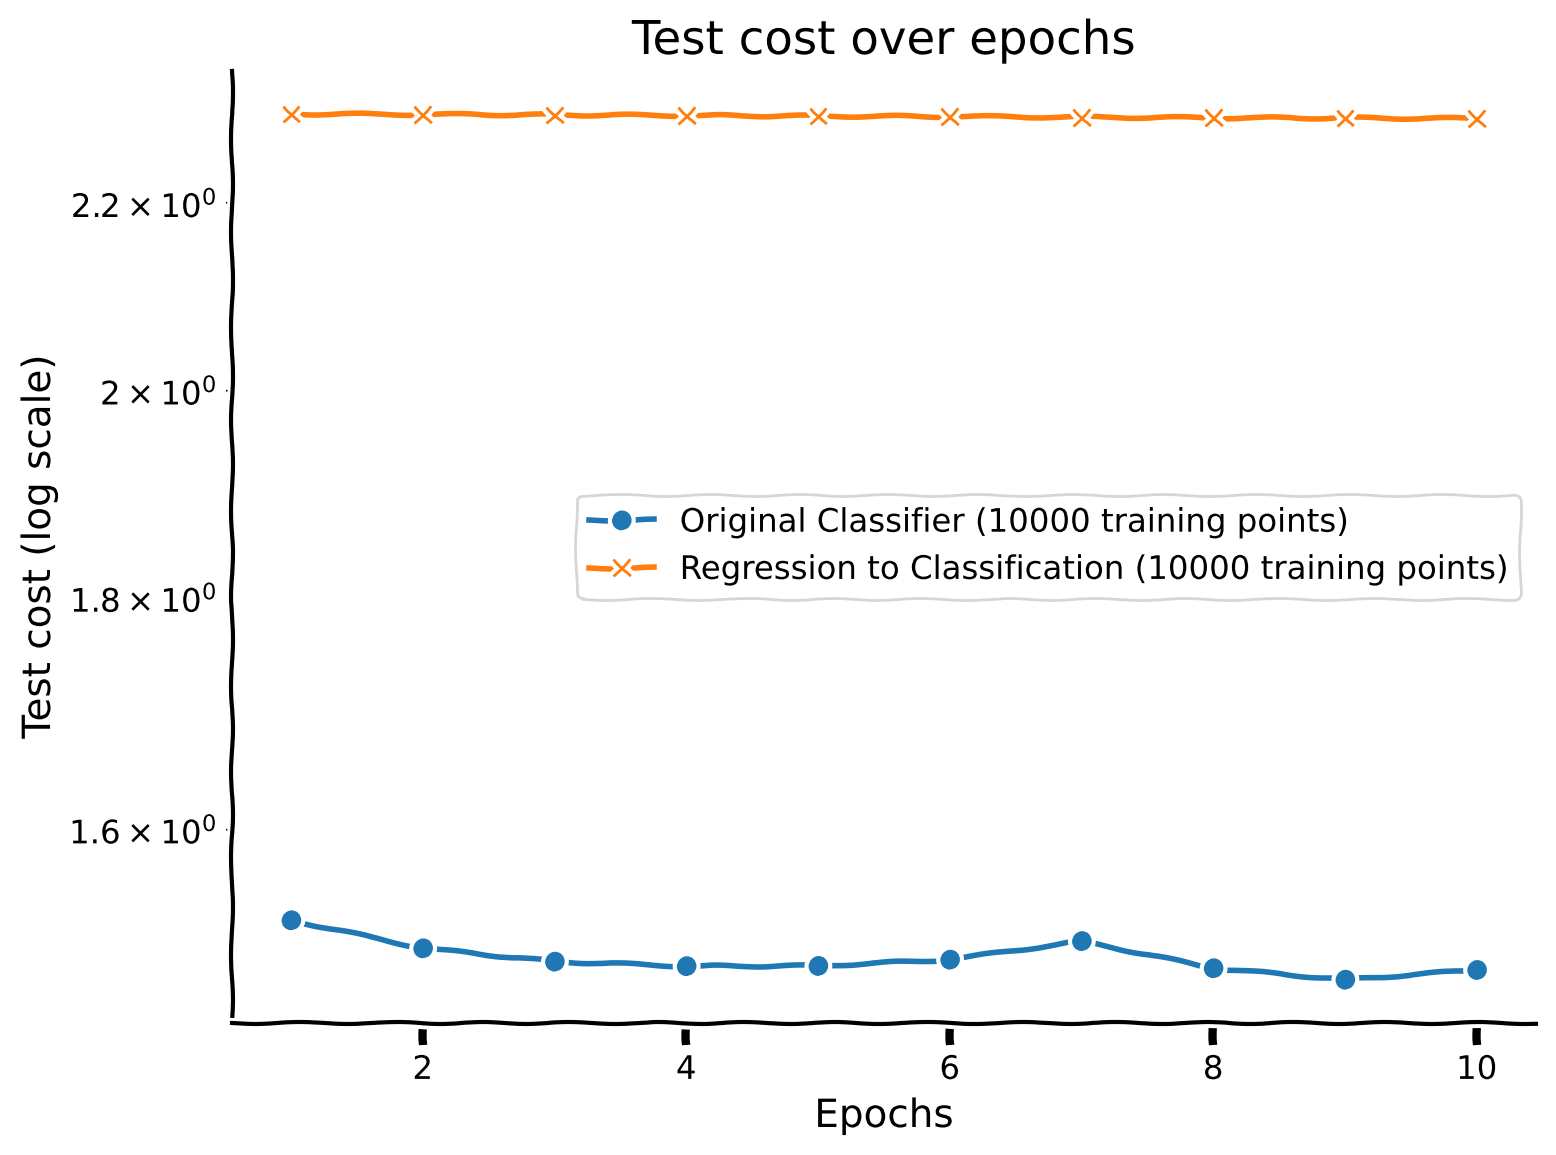

In [45]:
# Create a single plot for all training costs with a logarithmic scale
with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    epochs = my_epoch_Classification[-1]
    epochs_transfer_1 = my_epoch_transfer1
    test_cost = my_test_cost_Classification[-1]
    test_cost_1 = my_test_cost_transfer1

    # Plot the autoencoder training cost
    plt.plot(epochs, test_cost, marker='o', linestyle='-', label='Original Classifier (10000 training points)')

    # Plot the classification_autoencoder training cost
    plt.plot(epochs_transfer_1, test_cost_1, marker='x', linestyle='-', label='Regression to Classification (10000 training points)')

    # Set the labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs')
    plt.yscale('log')  # Set the y-axis to a logarithmic scale

    # Add the legend and grid
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

### Discussion point 5

What did the regression model learn? What does its performance on the classification task after fine-tuning indicate?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_430915db.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_5")

## Transfer example 2: autoencoder to classification

Now we do the same, but we transfer the weights of the network to predict the total number of "ON" pixels to the autoencoder task. How well do you think this will work? Think about the necessary features required to solve the task and consider if there could be much overlap. There is no clear answer to this question, but thinking about it will be useful.

In [46]:
MODEL_NAME_SOURCE = "models/ConvNet_autoencoder_10000_epoch_10.pth"
model_source = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))

# Load the checkpoint
checkpoint = torch.load(MODEL_NAME_SOURCE)

# Extract the state dictionary from the checkpoint
model_state_dict = checkpoint['model_state_dict']

# Load the state dictionary into the model
model_source.load_state_dict(model_state_dict)

# Define the destination model

model_destination = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())

# Number of layers to transfer and freeze
N = 8

# Transfer and freeze layers
copy_and_freeze_layers(model_source, model_destination, N)

['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc.weight', 'fc.bias']
Copied conv1.weight
Copied conv1.bias
Copied conv2.weight
Copied conv2.bias
Copied fc1.weight
Copied fc1.bias
Copied fc2.weight
Copied fc2.bias
8
froze  ConvNet.conv1.weight
froze  ConvNet.conv1.bias
froze  ConvNet.conv2.weight
froze  ConvNet.conv2.bias
froze  ConvNet.fc1.weight
froze  ConvNet.fc1.bias
froze  ConvNet.fc2.weight
froze  ConvNet.fc2.bias
Copied and froze 8 layers.


In [47]:
set_seed(42)

batch_size = 64  # Define your batch size

test_loader_transfer = DataLoader(dataset = test_dataset_transfer,
                                    batch_size = batch_size,
                                    shuffle = True)
sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data)

# Optimizer
optimizer = optim.Adam(params=model_destination.parameters(), lr=0.001)

# Training parameters
N_train_data = 10000
task_name = "autoencoder_classification"
epochs_max = 10  # Number of epochs
acc_flag = False  # Whether to calculate accuracy
triplet_flag = False  # Whether to use triplet loss

# Call the train_transfer function
my_epoch_transfer2, my_train_cost_transfer2, my_val_cost_transfer2, my_test_cost_transfer2 = train_transfer(
    model_destination,
    sampled_train_loader,
    sampled_val_loader,
    test_loader_transfer,
    cost_classification,
    optimizer,
    epochs_max,
    acc_flag,
    triplet_flag,
    task_name,
    N_train_data
)

Training epochs:  10%|█         | 1/10 [00:05<00:45,  5.01s/epoch]

Epoch: 1| Train cost:  2.10725| Val cost:  2.06486| Test cost:  2.04980|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:09<00:36,  4.53s/epoch]

Epoch: 2| Train cost:  2.06362| Val cost:  2.05435| Test cost:  2.04455|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:13<00:30,  4.37s/epoch]

Epoch: 3| Train cost:  1.99666| Val cost:  1.99084| Test cost:  1.96491|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:18<00:27,  4.59s/epoch]

Epoch: 4| Train cost:  1.97863| Val cost:  1.98831| Test cost:  1.96801|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:22<00:22,  4.42s/epoch]

Epoch: 5| Train cost:  1.97618| Val cost:  1.97805| Test cost:  1.96067|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:26<00:17,  4.33s/epoch]

Epoch: 6| Train cost:  1.97622| Val cost:  1.97821| Test cost:  1.95878|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:31<00:13,  4.53s/epoch]

Epoch: 7| Train cost:  1.97387| Val cost:  1.97680| Test cost:  1.95864|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:35<00:08,  4.44s/epoch]

Epoch: 8| Train cost:  1.97408| Val cost:  1.97551| Test cost:  1.96243|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:40<00:04,  4.51s/epoch]

Epoch: 9| Train cost:  1.97134| Val cost:  1.97610| Test cost:  1.96043|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:45<00:00,  4.51s/epoch]

Epoch: 10| Train cost:  1.97163| Val cost:  1.96823| Test cost:  1.95998|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_10.pth
Elapsed: 45.1149160861969


We compare the performance of the transferred model with the original network.

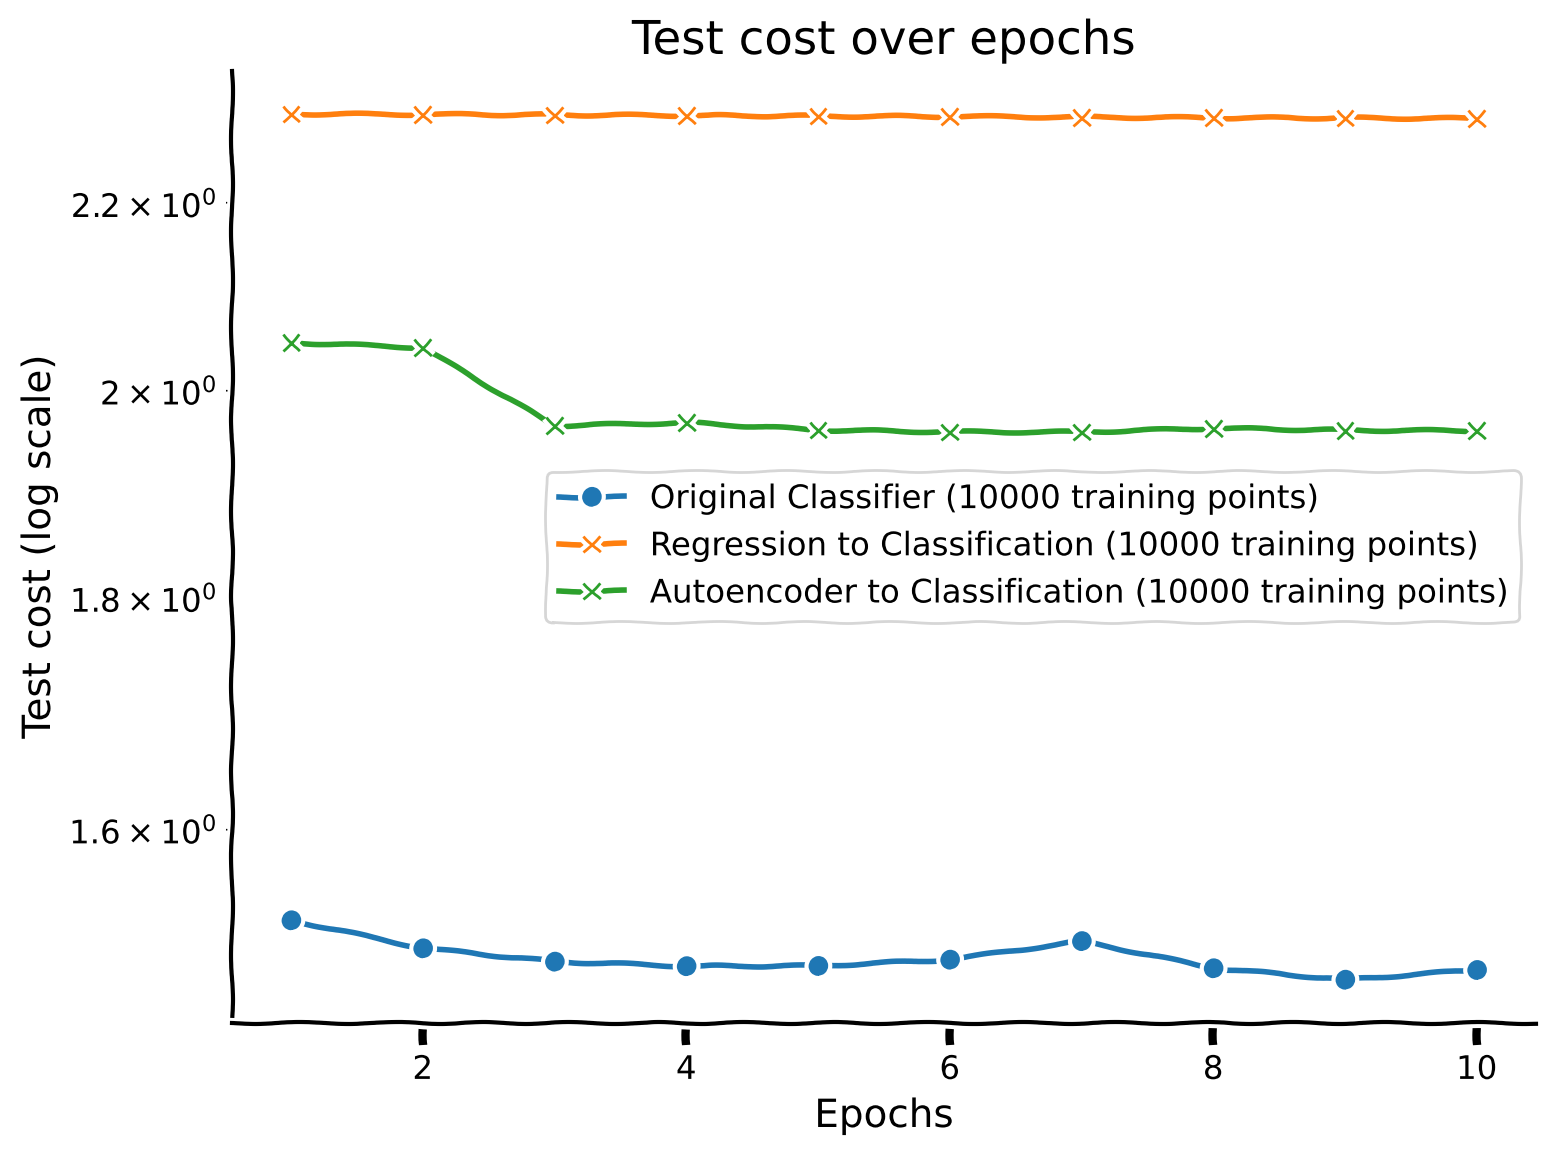

In [48]:
# Create a single plot for all training costs with a logarithmic scale
with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    epochs = my_epoch_Classification[-1]
    epochs_transfer_1 = my_epoch_transfer1
    epochs_transfer_2 = my_epoch_transfer2
    test_cost = my_test_cost_Classification[-1]
    test_cost_1 = my_test_cost_transfer1
    test_cost_2 = my_test_cost_transfer2

    # Plot the autoencoder training cost
    plt.plot(epochs, test_cost, marker='o', linestyle='-', label='Original Classifier (10000 training points)')

    # Plot the classification_autoencoder training cost
    plt.plot(epochs_transfer_1, test_cost_1, marker='x', linestyle='-', label='Regression to Classification (10000 training points)')

# Plot the classification_autoencoder training cost
    plt.plot(epochs_transfer_2, test_cost_2, marker='x', linestyle='-', label='Autoencoder to Classification (10000 training points)')

    # Set the labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs')
    plt.yscale('log')  # Set the y-axis to a logarithmic scale

    # Add the legend and grid
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

### Discussion point 6

How well does the representation learned on the autoencoder transfer to classification?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_733ba3ce.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_6")

## Transfer example 3: inpainting to classification

Finally, we'll transfer the weights of the inpainting network to the classification network. How well do you think this will work? Again, consider the breakdown of the features that would need to support both tasks. Is there an overlap?

In [49]:
MODEL_NAME_SOURCE = "models/ConvNet_inpainting_10000_epoch_10.pth"
M = 16
model_source = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))

# Load the checkpoint
checkpoint = torch.load(MODEL_NAME_SOURCE)

# Extract the state dictionary from the checkpoint
model_state_dict = checkpoint['model_state_dict']

# Load the state dictionary into the model
model_source.load_state_dict(model_state_dict)

# Define the destination model

model_destination = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())

# Number of layers to transfer and freeze
N = 8

# Transfer and freeze layers
copy_and_freeze_layers(model_source, model_destination, N)

['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc.weight', 'fc.bias']
Copied conv1.weight
Copied conv1.bias
Copied conv2.weight
Copied conv2.bias
Copied fc1.weight
Copied fc1.bias
Copied fc2.weight
Copied fc2.bias
8
froze  ConvNet.conv1.weight
froze  ConvNet.conv1.bias
froze  ConvNet.conv2.weight
froze  ConvNet.conv2.bias
froze  ConvNet.fc1.weight
froze  ConvNet.fc1.bias
froze  ConvNet.fc2.weight
froze  ConvNet.fc2.bias
Copied and froze 8 layers.


In [50]:
set_seed(42)

batch_size = 64  # Define your batch size

test_loader_transfer = torch.utils.data.DataLoader(dataset = test_dataset_transfer,
                                           batch_size = batch_size,
                                           shuffle = True)
sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data)

# Optimizer
optimizer = optim.Adam(params=model_destination.parameters(), lr=0.001)

# Training parameters
N_train_data = 10000
task_name = "inpainting_classification"
epochs_max = 10  # Number of epochs
acc_flag = False  # Whether to calculate accuracy
triplet_flag = False  # Whether to use triplet loss

# Call the train_transfer function
my_epoch_transfer3, my_train_cost_transfer3, my_val_cost_transfer3, my_test_cost_transfer3 = train_transfer(
    model_destination,
    sampled_train_loader,
    sampled_val_loader,
    test_loader_transfer,
    cost_classification,
    optimizer,
    epochs_max,
    acc_flag,
    triplet_flag,
    task_name,
    N_train_data
)

Training epochs:  10%|█         | 1/10 [00:04<00:39,  4.34s/epoch]

Epoch: 1| Train cost:  2.06929| Val cost:  2.00302| Test cost:  1.98073|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_1.pth


Training epochs:  20%|██        | 2/10 [00:08<00:33,  4.20s/epoch]

Epoch: 2| Train cost:  1.99341| Val cost:  1.97812| Test cost:  1.96150|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_2.pth


Training epochs:  30%|███       | 3/10 [00:13<00:31,  4.54s/epoch]

Epoch: 3| Train cost:  1.94097| Val cost:  1.91576| Test cost:  1.89842|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_3.pth


Training epochs:  40%|████      | 4/10 [00:17<00:26,  4.39s/epoch]

Epoch: 4| Train cost:  1.91909| Val cost:  1.90169| Test cost:  1.89287|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_4.pth


Training epochs:  50%|█████     | 5/10 [00:22<00:22,  4.42s/epoch]

Epoch: 5| Train cost:  1.91201| Val cost:  1.89209| Test cost:  1.88775|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_5.pth


Training epochs:  60%|██████    | 6/10 [00:26<00:17,  4.49s/epoch]

Epoch: 6| Train cost:  1.91064| Val cost:  1.89126| Test cost:  1.88320|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_6.pth


Training epochs:  70%|███████   | 7/10 [00:30<00:13,  4.43s/epoch]

Epoch: 7| Train cost:  1.90661| Val cost:  1.88953| Test cost:  1.88413|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_7.pth


Training epochs:  80%|████████  | 8/10 [00:35<00:09,  4.62s/epoch]

Epoch: 8| Train cost:  1.90541| Val cost:  1.88766| Test cost:  1.88114|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_8.pth


Training epochs:  90%|█████████ | 9/10 [00:40<00:04,  4.52s/epoch]

Epoch: 9| Train cost:  1.90358| Val cost:  1.88783| Test cost:  1.88240|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_9.pth


Training epochs: 100%|██████████| 10/10 [00:44<00:00,  4.45s/epoch]

Epoch: 10| Train cost:  1.90162| Val cost:  1.88477| Test cost:  1.88270|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_10.pth
Elapsed: 44.48909544944763


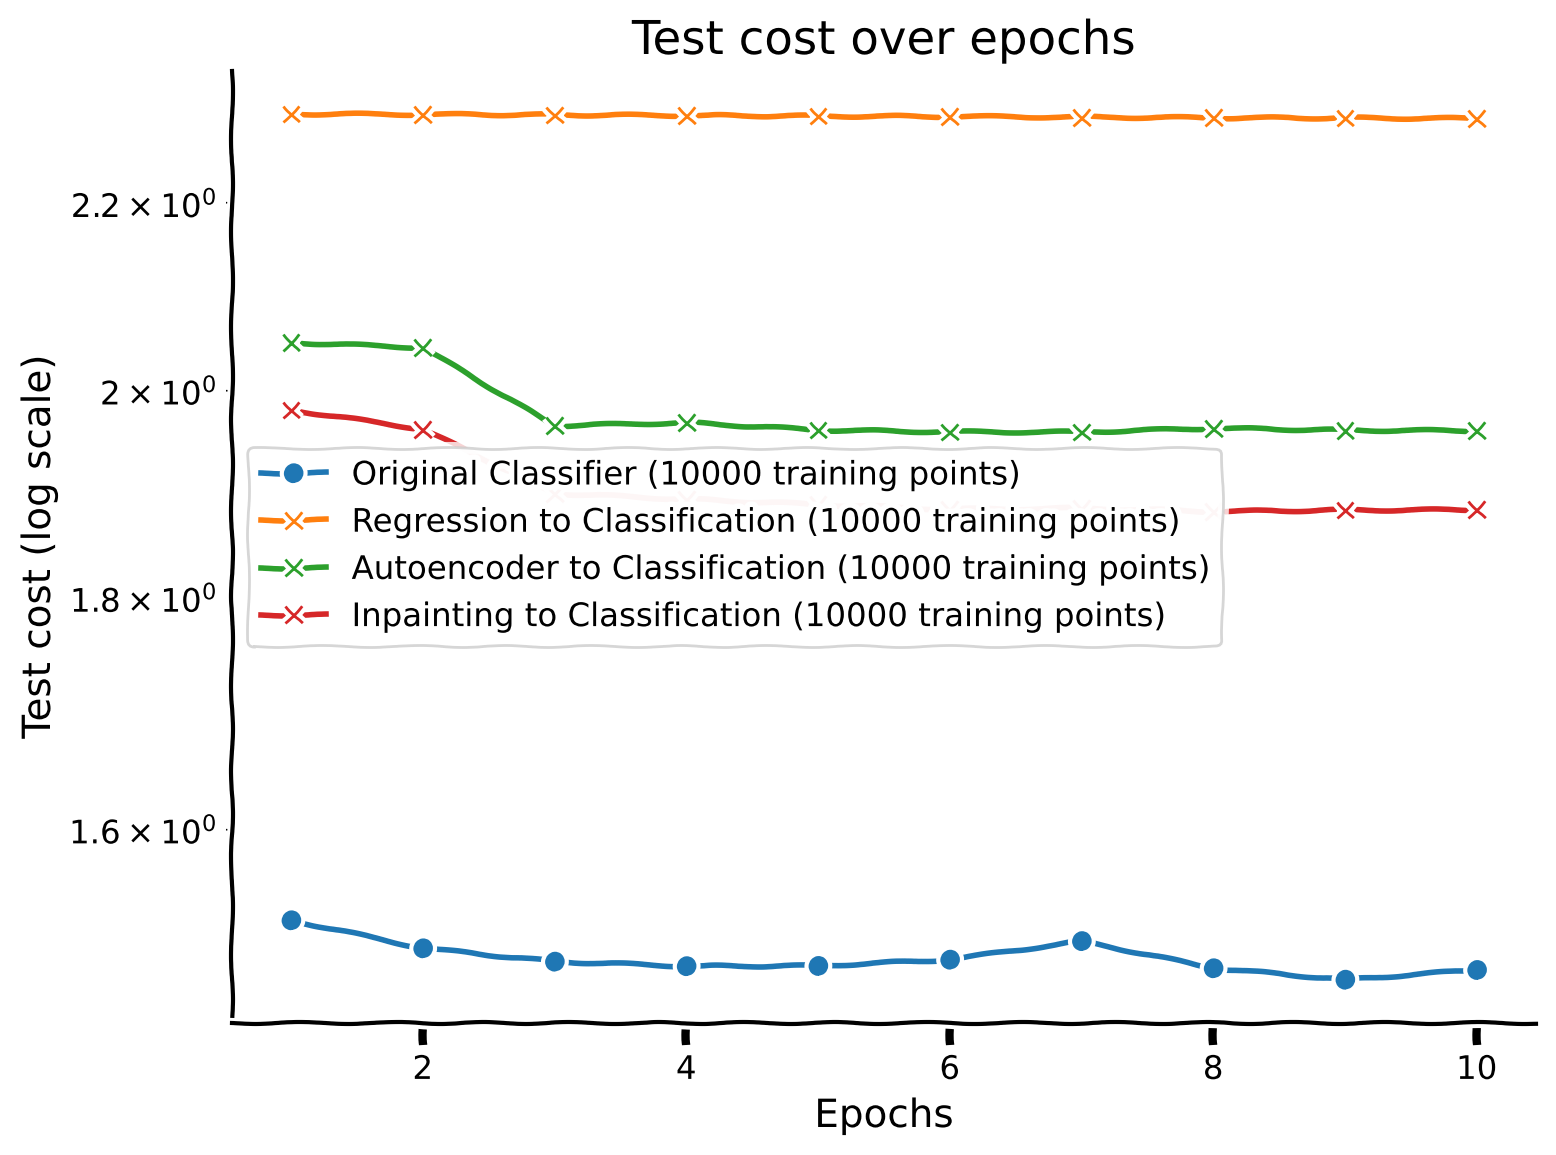

In [51]:
# Create a single plot for all training costs with a logarithmic scale
with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    epochs = my_epoch_Classification[-1]
    epochs_transfer_1 = my_epoch_transfer1
    epochs_transfer_2 = my_epoch_transfer2
    epochs_transfer_3 = my_epoch_transfer3
    test_cost = my_test_cost_Classification[-1]
    test_cost_1 = my_test_cost_transfer1
    test_cost_2 = my_test_cost_transfer2
    test_cost_3 = my_test_cost_transfer3

    plt.plot(epochs, test_cost, marker='o', linestyle='-', label='Original Classifier (10000 training points)')
    plt.plot(epochs_transfer_1, test_cost_1, marker='x', linestyle='-', label='Regression to Classification (10000 training points)')
    plt.plot(epochs_transfer_2, test_cost_2, marker='x', linestyle='-', label='Autoencoder to Classification (10000 training points)')
    plt.plot(epochs_transfer_3, test_cost_3, marker='x', linestyle='-', label='Inpainting to Classification (10000 training points)')

    # Set the labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs')
    plt.yscale('log')  # Set the y-axis to a logarithmic scale

    # Add the legend and grid
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

### Discussion point 7

Consider the test loss across these three networks (regression, autoencoder, inpainting). What does this test loss tell us about the representations learned by these networks?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_329eb9d7.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_7")

### Bonus discussion point 8


How would you find out if the representations learned by the networks are similar or different, apart from their performance on downstream tasks?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_9e82edae.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_8")

---
# The Big Picture

In this tutorial, we explored the concept of **generalization** of representation in AI, namely the concept of representational transfer. We trained networks on several distinct tasks including classification, regression, autoencoding, and inpainting. We showed how the specification of different cost functions on the output layers can make a network perform a completely different task. We specified multiple different cost functions that were each associated with defining one of the tasks outlined earler.

We explored how a network trained on one task might transfer to another task / network. We found that *richer* tasks, including inpainting and autoencoding, lead to more useful representations for downstream tasks like classification. These tasks involve needing to capture multiple pieces of information across local and global contexts, big picture features as well as smaller details.

Humans are great at generalization and we have limited neural networks that are re-used across many different tasks. Is this an idea we can take forward to creating better AI models?